In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

In [2]:
train=pd.read_csv("./train.csv", parse_dates=[0]) # 日付をdatetime型で取得
test=pd.read_csv("./test.csv", parse_dates=[0])
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2466 non-null   datetime64[ns]
 1   y         2101 non-null   float64       
 2   client    2466 non-null   int64         
 3   close     2466 non-null   int64         
 4   price_am  2466 non-null   int64         
 5   price_pm  2466 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.9 KB


,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,-1,-1
1,2010-07-02,18.0,0,0,-1,-1
2,2010-07-03,20.0,0,0,-1,-1
3,2010-07-04,20.0,0,0,-1,-1
4,2010-07-05,14.0,0,0,-1,-1
5,2010-07-06,14.0,0,0,-1,-1
6,2010-07-07,4.0,0,0,-1,-1
7,2010-07-08,10.0,0,0,-1,-1
8,2010-07-09,12.0,0,0,-1,-1
9,2010-07-10,21.0,0,0,-1,-1


In [3]:
df.loc[df['price_am'] == -1, 'price_am'] = np.nan
df.loc[df['price_pm'] == -1, 'price_pm'] = np.nan
df.head()

,datetime,y,client,close,price_am,price_pm
0,2010-07-01,17.0,0,0,NaN,NaN
1,2010-07-02,18.0,0,0,NaN,NaN
2,2010-07-03,20.0,0,0,NaN,NaN
3,2010-07-04,20.0,0,0,NaN,NaN
4,2010-07-05,14.0,0,0,NaN,NaN


In [4]:
### datimeをdatetime64[ns]型に変更。

In [5]:
#df['datetime'] = df.datetime.map(dt.datetime.timestamp)
#df['datetime'] = df['datetime'].dt.to_pydatetime()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday

In [6]:
#df=df.drop(['datetime','year'], axis=1)
df=df.drop(['datetime'], axis=1)

### Fill na

In [7]:
df['price_am'] = df.groupby(['month', 'weekday'])['price_am'].transform(lambda x: x.fillna(x.mean()))
df['price_pm'] = df.groupby(['month', 'weekday'])['price_pm'].transform(lambda x: x.fillna(x.mean()))

### New features

In [8]:
df['price'] = (df['price_am'] + df['price_pm'])/2

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   y         2101 non-null   float64
 1   client    2466 non-null   int64  
 2   close     2466 non-null   int64  
 3   price_am  2466 non-null   float64
 4   price_pm  2466 non-null   float64
 5   year      2466 non-null   int64  
 6   month     2466 non-null   int64  
 7   day       2466 non-null   int64  
 8   weekday   2466 non-null   int64  
 9   price     2466 non-null   float64
dtypes: float64(4), int64(6)
memory usage: 211.9 KB


In [10]:
df['client'] = df['client'].astype(str)
df['close'] = df['close'].astype(str)
df['month'] = df['month'].astype(str)
df['weekday'] = df['weekday'].astype(str)

In [11]:
pd.set_option('display.max_rows', None)
print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
print(df.groupby(['year'])['price_am','price_pm','y'].mean())

               price_am  price_pm          y
month weekday                               
1     0        0.142857  0.000000  23.423077
      1        0.107143  0.071429  21.846154
      2        0.035714  0.000000  22.692308
      3        0.178571  0.107143  21.296296
      4        0.285714  0.178571  27.444444
      5        0.892857  0.464286  36.296296
      6        0.428571  0.250000  32.666667
10    0        0.518519  0.192308  28.538462
      1        0.192308  0.076923  25.769231
      2        0.185185  0.074074  28.148148
      3        0.222222  0.148148  29.481481
      4        0.500000  0.269231  32.222222
      5        1.629630  1.111111  39.000000
      6        1.346154  0.730769  35.269231
11    0        0.120000  0.040000  28.576923
      1        0.153846  0.076923  24.000000
      2        0.153846  0.076923  24.280000
      3        0.160000  0.080000  26.120000
      4        0.423077  0.269231  32.269231
      5        1.423077  1.000000  38.884615
      6   

<ipython-input-11-ab1e28b0b82f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['month', 'weekday'])['price_am','price_pm','y'].mean())
<ipython-input-11-ab1e28b0b82f>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print(df.groupby(['year'])['price_am','price_pm','y'].mean())


In [12]:
#divide dataset into two parts(categorical, contineous)
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['client', 'close', 'month', 'weekday']

NumericaL:
['y', 'price_am', 'price_pm', 'year', 'day', 'price']


### Pandas Profining

In [13]:
#import pandas_profiling

#df.profile_report()

### Heat map for Correlation coefficient

<AxesSubplot:>

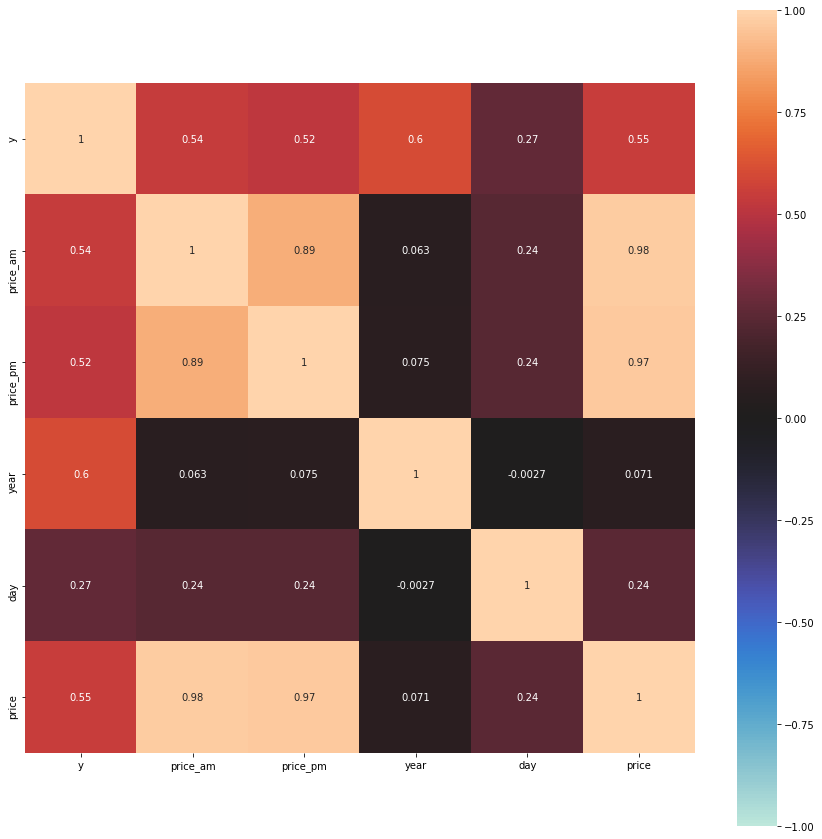

In [14]:
df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Histogram

C:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


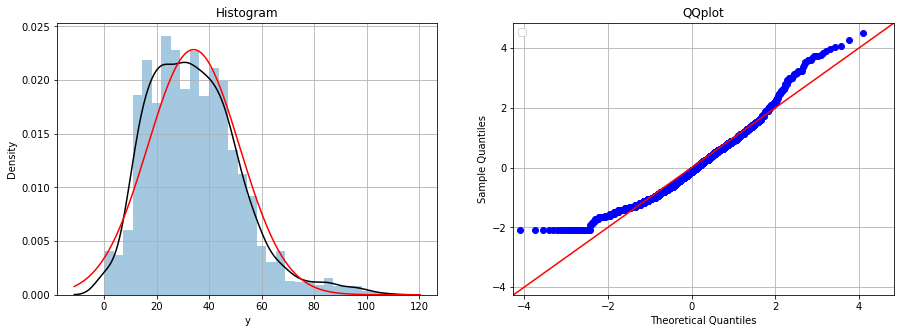

In [15]:
fig, ax = plt.subplots(1,2, figsize= (15,5))
# Histogram
sns.distplot(
    train['y'], label='y',
    kde_kws={'label': 'kde','color':'k'},
    fit=norm,fit_kws={'label': 'norm','color':'red'},
    ax = ax[0]
)
ax[0].set_title("Histogram")
ax[0].grid(True)

# QQplot
sm.qqplot(train['y'], stats.t, distargs=(4,),fit=True, line="45", ax = ax[1])
ax[1].set_title("QQplot")
ax[1].grid(True)

plt.legend() # 凡例を表示
plt.show() #グラフ表示

### Dummy

In [16]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

In [17]:
df.head(10)

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,14.0,0.333333,0.148148,2010,6,0.240741,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,4.0,0.259259,0.111111,2010,7,0.185185,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
7,10.0,0.192308,0.076923,2010,8,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
8,12.0,0.692308,0.423077,2010,9,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
9,21.0,1.807692,1.192308,2010,10,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Separate Data

In [18]:
train = df[:len(train)]
test = df[len(train):]

In [19]:
y_train = train['y']
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)

In [20]:
### 線形回帰

In [21]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2466 entries, 0 to 364
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          2101 non-null   float64
 1   price_am   2466 non-null   float64
 2   price_pm   2466 non-null   float64
 3   year       2466 non-null   int64  
 4   day        2466 non-null   int64  
 5   price      2466 non-null   float64
 6   client_1   2466 non-null   uint8  
 7   close_1    2466 non-null   uint8  
 8   month_10   2466 non-null   uint8  
 9   month_11   2466 non-null   uint8  
 10  month_12   2466 non-null   uint8  
 11  month_2    2466 non-null   uint8  
 12  month_3    2466 non-null   uint8  
 13  month_4    2466 non-null   uint8  
 14  month_5    2466 non-null   uint8  
 15  month_6    2466 non-null   uint8  
 16  month_7    2466 non-null   uint8  
 17  month_8    2466 non-null   uint8  
 18  month_9    2466 non-null   uint8  
 19  weekday_1  2466 non-null   uint8  
 20  weekday_2

,y,price_am,price_pm,year,day,price,client_1,close_1,month_10,month_11,...,month_6,month_7,month_8,month_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,17.0,0.192308,0.076923,2010,1,0.134615,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,18.0,0.692308,0.423077,2010,2,0.557692,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,20.0,1.807692,1.192308,2010,3,1.500000,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,20.0,1.407407,0.925926,2010,4,1.166667,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,14.0,0.346154,0.192308,2010,5,0.269231,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# データセットの標準化準備
scaler= StandardScaler()
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)


In [24]:
# Lasso 交差検証準備
# clf = LassoCV(alphas=10 ** np.arange(-6, 1, 0.1), cv = 5)

params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Lasso(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
lasso_tuned = clf.best_estimator_

# 予測値を反映
y_lasso_pred = lasso_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_lasso_test_pred = lasso_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_lasso_pred)))
#print(cross_val_score(clf, X_train_scaler, y_train, cv=5))

{'alpha': 0.025118864315094896}
R^2 = 0.7392186103726259
MAE = 6.871768390587337


In [25]:
# SVM

params_grid = [
    {'C': [1, 10, 100], 'kernel':['linear']},
    {'C': [1, 10, 100], 'gamma': [0.01, 0.001], 'kernel': ['rbf']}
]
# パラメータチューニング
clf = GridSearchCV(
    estimator = SVC(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
#clf = RandomForestClassifier(max_depth=10, random_state=0)

# フィッテイング
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
svc_tuned = clf.best_estimator_

# 予測値を反映
y_svc_pred = svc_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_svc_test_pred = svc_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))

print(best_param)
print("Score = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_svc_pred)))
#print(cross_val_score(clf, X_train, y_train, cv=5))

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Score = 0.7963997552009829
MAE = 4.990480723465017


In [26]:
import optuna.integration.lightgbm as lgb # Optuna 
#import lightgbm as lgb 
from sklearn.model_selection import KFold

In [27]:
X_train['SVC'] = y_svc_pred
X_test['SVC'] = y_svc_test_pred
# データセットの標準化
scaler.fit(X_train)
scaler.fit(X_test)
X_train_scaler = scaler.transform(X_train)
X_test_scaler  = scaler.transform(X_test)

In [28]:
y_lgb_preds = []
models = []
y_lgb_oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective': 'regression',
    'metric' : 'rmse',
    'max_bin' : 255,
    'num_leaves' : 31,
    'learning_rate' : 0.05,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : -1
}

# Cross Validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    # Train Dataset
    lgb_train = lgb.Dataset(X_tr, y_tr)

    # Evaluation Dataset (early_stopping_rounds)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    evals_result = {} #結果を格納するための辞書
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
    # Out-of-hold of train data
    y_lgb_oof_train[valid_index] = \
        gbm.predict(X_val, num_iteration=gbm.best_iteration)

    
    # Prediction for X_test data
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    # Append Prediction data 
    y_lgb_preds.append(y_pred)
    models.append(gbm)

print(mean_absolute_error(y_train, y_lgb_oof_train))


[I 2021-06-20 17:56:19,123] A new study created in memory with name: no-name-88cf51ff-243a-48af-ae93-b3800b96aaa9
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.37287	eval's rmse: 6.73906
[200]	train's rmse: 4.45751	eval's rmse: 6.55916
[300]	train's rmse: 3.91489	eval's rmse: 6.54546
[400]	train's rmse: 3.53292	eval's rmse: 6.49259
Early stopping, best iteration is:
[388]	train's rmse: 3.57163	eval's rmse: 6.46966


feature_fraction, val_score: 6.469663:  14%|######4                                      | 1/7 [00:00<00:05,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74034	eval's rmse: 6.79945
[200]	train's rmse: 4.87014	eval's rmse: 6.62272
[300]	train's rmse: 4.36486	eval's rmse: 6.57538
[400]	train's rmse: 4.01319	eval's rmse: 6.55583
[500]	train's rmse: 3.74359	eval's rmse: 6.53232
[600]	train's rmse: 3.50382	eval's rmse: 6.53375
Early stopping, best iteration is:
[545]	train's rmse: 3.63204	eval's rmse: 6.5201


feature_fraction, val_score: 6.469663:  29%|############8                                | 2/7 [00:02<00:05,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98357	eval's rmse: 6.89297
[200]	train's rmse: 5.17052	eval's rmse: 6.65873
[300]	train's rmse: 4.67664	eval's rmse: 6.59796


feature_fraction, val_score: 6.469663:  43%|###################2                         | 3/7 [00:02<00:03,  1.11it/s]

[400]	train's rmse: 4.33384	eval's rmse: 6.5746
Early stopping, best iteration is:
[334]	train's rmse: 4.54317	eval's rmse: 6.5586
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60136	eval's rmse: 6.73422
[200]	train's rmse: 4.70493	eval's rmse: 6.54361
[300]	train's rmse: 4.20211	eval's rmse: 6.52497
[400]	train's rmse: 3.85463	eval's rmse: 6.54005
Early stopping, best iteration is:
[331]	train's rmse: 4.08654	eval's rmse: 6.50222


feature_fraction, val_score: 6.469663:  57%|#########################7                   | 4/7 [00:03<00:02,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.49411	eval's rmse: 6.7573
[200]	train's rmse: 4.60941	eval's rmse: 6.61002
[300]	train's rmse: 4.09224	eval's rmse: 6.55165
[400]	train's rmse: 3.727	eval's rmse: 6.56423
Early stopping, best iteration is:
[385]	train's rmse: 3.77698	eval's rmse: 6.54231


feature_fraction, val_score: 6.469663:  71%|################################1            | 5/7 [00:04<00:01,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.41323	eval's rmse: 6.76847
[200]	train's rmse: 4.53222	eval's rmse: 6.61605
[300]	train's rmse: 4.02279	eval's rmse: 6.56196
[400]	train's rmse: 3.6513	eval's rmse: 6.5251
Early stopping, best iteration is:
[390]	train's rmse: 3.68637	eval's rmse: 6.50844


feature_fraction, val_score: 6.469663:  86%|######################################5      | 6/7 [00:05<00:00,  1.18it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43394	eval's rmse: 6.80006
[200]	train's rmse: 4.51948	eval's rmse: 6.60963
[300]	train's rmse: 3.99638	eval's rmse: 6.56983


num_leaves, val_score: 6.469663:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[251]	train's rmse: 4.2269	eval's rmse: 6.55666
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454
[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


num_leaves, val_score: 6.469663:   5%|##5                                               | 1/20 [00:01<00:18,  1.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  10%|#####                                             | 2/20 [00:02<00:18,  1.01s/it]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.36159	eval's rmse: 7.54452
[200]	train's rmse: 6.97309	eval's rmse: 7.31664
[300]	train's rmse: 6.77108	eval's rmse: 7.19428
[400]	train's rmse: 6.61027	eval's rmse: 7.07124
[500]	train's rmse: 6.47573	eval's rmse: 7.01894


num_leaves, val_score: 6.469663:  10%|#####                                             | 2/20 [00:02<00:18,  1.01s/it]

[600]	train's rmse: 6.37037	eval's rmse: 6.95401
[700]	train's rmse: 6.25383	eval's rmse: 6.90146
[800]	train's rmse: 6.17281	eval's rmse: 6.85131
[900]	train's rmse: 6.0868	eval's rmse: 6.82645
[1000]	train's rmse: 6.0224	eval's rmse: 6.77979
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.0224	eval's rmse: 6.77979


num_leaves, val_score: 6.469663:  15%|#######5                                          | 3/20 [00:02<00:13,  1.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78488	eval's rmse: 7.29732
[200]	train's rmse: 6.27091	eval's rmse: 7.05655
[300]	train's rmse: 5.96717	eval's rmse: 6.88921
[400]	train's rmse: 5.72135	eval's rmse: 6.78095


num_leaves, val_score: 6.469663:  15%|#######5                                          | 3/20 [00:02<00:13,  1.31it/s]

[500]	train's rmse: 5.54632	eval's rmse: 6.7541
[600]	train's rmse: 5.38946	eval's rmse: 6.70479
[700]	train's rmse: 5.24739	eval's rmse: 6.65476
Early stopping, best iteration is:
[685]	train's rmse: 5.26338	eval's rmse: 6.63537


num_leaves, val_score: 6.469663:  20%|##########                                        | 4/20 [00:02<00:10,  1.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.52335	eval's rmse: 7.14753
[200]	train's rmse: 5.96709	eval's rmse: 6.88812
[300]	train's rmse: 5.63634	eval's rmse: 6.75849
[400]	train's rmse: 5.3651	eval's rmse: 6.62938
[500]	train's rmse: 5.16814	eval's rmse: 6.59155
[600]	train's rmse: 4.99695	eval's rmse: 6.54106
[700]	train's rmse: 4.85017	eval's rmse: 6.53477


num_leaves, val_score: 6.469663:  25%|############5                                     | 5/20 [00:03<00:09,  1.51it/s]

Early stopping, best iteration is:
[685]	train's rmse: 4.86937	eval's rmse: 6.50385
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30536	eval's rmse: 6.81395
[200]	train's rmse: 4.35166	eval's rmse: 6.61729
[300]	train's rmse: 3.78849	eval's rmse: 6.5538
[400]	train's rmse: 3.38462	eval's rmse: 6.56468
Early stopping, best iteration is:
[318]	train's rmse: 3.70353	eval's rmse: 6.54019


num_leaves, val_score: 6.469663:  30%|###############                                   | 6/20 [00:04<00:10,  1.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  35%|#################5                                | 7/20 [00:05<00:10,  1.24it/s]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  40%|####################                              | 8/20 [00:06<00:11,  1.07it/s]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


[I 2021-06-20 17:56:31,660] Trial 14 finished with value: 6.593436084519589 and parameters: {'num_leaves': 231}. Best is trial 11 with value: 6.503845061548317.
num_leaves, val_score: 6.469663:  40%|####################                              | 8/20 [00:06<00:11,  1.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  40%|####################                              | 8/20 [00:07<00:11,  1.07it/s]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


num_leaves, val_score: 6.469663:  45%|######################5                           | 9/20 [00:07<00:10,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  50%|########################5                        | 10/20 [00:08<00:09,  1.00it/s]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.469663:  55%|##########################9                      | 11/20 [00:09<00:09,  1.02s/it]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


[I 2021-06-20 17:56:34,848] Trial 17 finished with value: 6.593436084519589 and parameters: {'num_leaves': 179}. Best is trial 11 with value: 6.503845061548317.
num_leaves, val_score: 6.469663:  55%|##########################9                      | 11/20 [00:09<00:09,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30888	eval's rmse: 6.73502
[200]	train's rmse: 4.33511	eval's rmse: 6.53559
[300]	train's rmse: 3.77106	eval's rmse: 6.50132
[400]	train's rmse: 3.36049	eval's rmse: 6.4658
Early stopping, best iteration is:
[389]	train's rmse: 3.40099	eval's rmse: 6.44473


num_leaves, val_score: 6.444728:  60%|#############################4                   | 12/20 [00:10<00:08,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.78488	eval's rmse: 7.29732
[200]	train's rmse: 6.27091	eval's rmse: 7.05655
[300]	train's rmse: 5.96717	eval's rmse: 6.88921
[400]	train's rmse: 5.72135	eval's rmse: 6.78095


num_leaves, val_score: 6.444728:  60%|#############################4                   | 12/20 [00:11<00:08,  1.01s/it]

[500]	train's rmse: 5.54632	eval's rmse: 6.7541
[600]	train's rmse: 5.38946	eval's rmse: 6.70479
[700]	train's rmse: 5.24739	eval's rmse: 6.65476
Early stopping, best iteration is:
[685]	train's rmse: 5.26338	eval's rmse: 6.63537


num_leaves, val_score: 6.444728:  65%|###############################8                 | 13/20 [00:11<00:06,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.16664	eval's rmse: 6.81802
[200]	train's rmse: 4.13543	eval's rmse: 6.67852
[300]	train's rmse: 3.5227	eval's rmse: 6.65637


num_leaves, val_score: 6.444728:  70%|##################################3              | 14/20 [00:12<00:04,  1.21it/s]

Early stopping, best iteration is:
[255]	train's rmse: 3.76927	eval's rmse: 6.63338
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.444728:  70%|##################################3              | 14/20 [00:13<00:04,  1.21it/s]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


num_leaves, val_score: 6.444728:  75%|####################################7            | 15/20 [00:13<00:04,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.6859	eval's rmse: 6.84856
[200]	train's rmse: 4.85515	eval's rmse: 6.62111
[300]	train's rmse: 4.38643	eval's rmse: 6.53663
[400]	train's rmse: 4.03585	eval's rmse: 6.49609
Early stopping, best iteration is:
[390]	train's rmse: 4.06801	eval's rmse: 6.48617


num_leaves, val_score: 6.444728:  80%|#######################################2         | 16/20 [00:14<00:03,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.444728:  85%|#########################################6       | 17/20 [00:15<00:03,  1.12s/it]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28424	eval's rmse: 6.70564
[200]	train's rmse: 4.30956	eval's rmse: 6.52733
[300]	train's rmse: 3.7437	eval's rmse: 6.52086


num_leaves, val_score: 6.444728:  90%|############################################1    | 18/20 [00:16<00:02,  1.03s/it]

Early stopping, best iteration is:
[235]	train's rmse: 4.08357	eval's rmse: 6.50266
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.444728:  90%|############################################1    | 18/20 [00:17<00:02,  1.03s/it]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


num_leaves, val_score: 6.444728:  95%|##############################################5  | 19/20 [00:17<00:01,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.12097	eval's rmse: 6.789
[200]	train's rmse: 4.08001	eval's rmse: 6.66507
[300]	train's rmse: 3.47245	eval's rmse: 6.61454


num_leaves, val_score: 6.444728:  95%|##############################################5  | 19/20 [00:18<00:01,  1.04s/it]

[400]	train's rmse: 3.03365	eval's rmse: 6.64783
Early stopping, best iteration is:
[315]	train's rmse: 3.39537	eval's rmse: 6.59344


bagging, val_score: 6.444728:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34114	eval's rmse: 6.83819
[200]	train's rmse: 4.39551	eval's rmse: 6.7026
[300]	train's rmse: 3.84311	eval's rmse: 6.62848
[400]	train's rmse: 3.43288	eval's rmse: 6.56712
[500]	train's rmse: 3.1161	eval's rmse: 6.58638
Early stopping, best iteration is:
[420]	train's rmse: 3.36498	eval's rmse: 6.54383


bagging, val_score: 6.444728:  10%|#####3                                               | 1/10 [00:03<00:27,  3.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.68461	eval's rmse: 7.01165
[200]	train's rmse: 4.80879	eval's rmse: 6.80105
[300]	train's rmse: 4.2755	eval's rmse: 6.68837
[400]	train's rmse: 3.88971	eval's rmse: 6.64466
[500]	train's rmse: 3.57702	eval's rmse: 6.65328
Early stopping, best iteration is:
[424]	train's rmse: 3.80793	eval's rmse: 6.62442


bagging, val_score: 6.444728:  20%|##########6                                          | 2/10 [00:05<00:19,  2.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.10423	eval's rmse: 6.69078
[200]	train's rmse: 4.11915	eval's rmse: 6.55896
[300]	train's rmse: 3.57661	eval's rmse: 6.51847


bagging, val_score: 6.444728:  30%|###############9                                     | 3/10 [00:06<00:13,  1.90s/it]

Early stopping, best iteration is:
[280]	train's rmse: 3.67144	eval's rmse: 6.50785
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.0731	eval's rmse: 6.99821
[200]	train's rmse: 5.31296	eval's rmse: 6.71242


bagging, val_score: 6.444728:  40%|#####################2                               | 4/10 [00:07<00:08,  1.48s/it]

Early stopping, best iteration is:
[192]	train's rmse: 5.35678	eval's rmse: 6.67771
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34954	eval's rmse: 6.80745
[200]	train's rmse: 4.4086	eval's rmse: 6.63982
[300]	train's rmse: 3.85783	eval's rmse: 6.62845


bagging, val_score: 6.444728:  50%|##########################5                          | 5/10 [00:08<00:08,  1.60s/it]

Early stopping, best iteration is:
[282]	train's rmse: 3.93781	eval's rmse: 6.59465
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.08512	eval's rmse: 7.23441
[200]	train's rmse: 5.31837	eval's rmse: 7.06525
[300]	train's rmse: 4.82602	eval's rmse: 7.02348
[400]	train's rmse: 4.46796	eval's rmse: 6.97073
[500]	train's rmse: 4.21974	eval's rmse: 6.91362


bagging, val_score: 6.444728:  60%|###############################8                     | 6/10 [00:10<00:06,  1.64s/it]

Early stopping, best iteration is:
[480]	train's rmse: 4.26574	eval's rmse: 6.87245
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74372	eval's rmse: 7.11903
[200]	train's rmse: 4.82099	eval's rmse: 6.89212
[300]	train's rmse: 4.30083	eval's rmse: 6.7931
[400]	train's rmse: 3.88717	eval's rmse: 6.7234
[500]	train's rmse: 3.58659	eval's rmse: 6.6939
Early stopping, best iteration is:
[429]	train's rmse: 3.78993	eval's rmse: 6.6667


bagging, val_score: 6.444728:  70%|#####################################                | 7/10 [00:13<00:05,  1.93s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.26445	eval's rmse: 6.82625
[200]	train's rmse: 4.31503	eval's rmse: 6.61511
[300]	train's rmse: 3.72943	eval's rmse: 6.57045


bagging, val_score: 6.444728:  80%|##########################################4          | 8/10 [00:15<00:03,  1.96s/it]

Early stopping, best iteration is:
[234]	train's rmse: 4.08786	eval's rmse: 6.56093
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.11842	eval's rmse: 6.74446
[200]	train's rmse: 4.16316	eval's rmse: 6.54373
[300]	train's rmse: 3.6216	eval's rmse: 6.52606
Early stopping, best iteration is:
[268]	train's rmse: 3.77248	eval's rmse: 6.49753


bagging, val_score: 6.444728:  90%|###############################################7     | 9/10 [00:16<00:01,  1.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82398	eval's rmse: 6.97811
[200]	train's rmse: 4.98767	eval's rmse: 6.8184
[300]	train's rmse: 4.48233	eval's rmse: 6.68207
[400]	train's rmse: 4.11779	eval's rmse: 6.61618


feature_fraction_stage2, val_score: 6.444728:   0%|                                              | 0/3 [00:00<?, ?it/s]

[500]	train's rmse: 3.80943	eval's rmse: 6.67873
Early stopping, best iteration is:
[410]	train's rmse: 4.07705	eval's rmse: 6.6097
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32045	eval's rmse: 6.7738
[200]	train's rmse: 4.3468	eval's rmse: 6.59617
[300]	train's rmse: 3.78478	eval's rmse: 6.55176
[400]	train's rmse: 3.38481	eval's rmse: 6.5291


feature_fraction_stage2, val_score: 6.444728:  33%|############6                         | 1/3 [00:01<00:02,  1.46s/it]

Early stopping, best iteration is:
[386]	train's rmse: 3.43328	eval's rmse: 6.51782
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30888	eval's rmse: 6.73502
[200]	train's rmse: 4.33511	eval's rmse: 6.53559
[300]	train's rmse: 3.77106	eval's rmse: 6.50132
[400]	train's rmse: 3.36049	eval's rmse: 6.4658


feature_fraction_stage2, val_score: 6.444728:  67%|#########################3            | 2/3 [00:03<00:01,  1.56s/it]

Early stopping, best iteration is:
[389]	train's rmse: 3.40099	eval's rmse: 6.44473
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31423	eval's rmse: 6.73306
[200]	train's rmse: 4.35807	eval's rmse: 6.55425
[300]	train's rmse: 3.79543	eval's rmse: 6.54422
Early stopping, best iteration is:
[225]	train's rmse: 4.18911	eval's rmse: 6.50671


regularization_factors, val_score: 6.444728:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27667	eval's rmse: 6.75894
[200]	train's rmse: 4.33898	eval's rmse: 6.5703


regularization_factors, val_score: 6.444728:   5%|#9                                    | 1/20 [00:01<00:22,  1.17s/it]

[300]	train's rmse: 3.78735	eval's rmse: 6.55542
Early stopping, best iteration is:
[225]	train's rmse: 4.17318	eval's rmse: 6.52263
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57877	eval's rmse: 6.80096
[200]	train's rmse: 4.68358	eval's rmse: 6.61781
[300]	train's rmse: 4.17657	eval's rmse: 6.56989
Early stopping, best iteration is:
[255]	train's rmse: 4.37487	eval's rmse: 6.54899


regularization_factors, val_score: 6.444728:  10%|###8                                  | 2/20 [00:02<00:21,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31642	eval's rmse: 6.7076
[200]	train's rmse: 4.32899	eval's rmse: 6.56535


regularization_factors, val_score: 6.444728:  10%|###8                                  | 2/20 [00:03<00:21,  1.18s/it]

[300]	train's rmse: 3.77221	eval's rmse: 6.56594
Early stopping, best iteration is:
[235]	train's rmse: 4.11106	eval's rmse: 6.53683


regularization_factors, val_score: 6.444728:  15%|#####7                                | 3/20 [00:03<00:19,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56927	eval's rmse: 6.75517
[200]	train's rmse: 4.66241	eval's rmse: 6.57064
[300]	train's rmse: 4.14982	eval's rmse: 6.54509


regularization_factors, val_score: 6.444728:  20%|#######6                              | 4/20 [00:04<00:15,  1.03it/s]

Early stopping, best iteration is:
[235]	train's rmse: 4.45554	eval's rmse: 6.51018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.28082	eval's rmse: 6.75015
[200]	train's rmse: 4.34	eval's rmse: 6.58816


regularization_factors, val_score: 6.444728:  25%|#########5                            | 5/20 [00:05<00:16,  1.08s/it][I 2021-06-20 17:57:12,110] Trial 44 finished with value: 6.525597316476128 and parameters: {'lambda_l1': 3.0837636937967322e-06, 'lambda_l2': 7.64165181024252e-05}. Best is trial 43 with value: 6.510181182785227.


[300]	train's rmse: 3.77188	eval's rmse: 6.56982
Early stopping, best iteration is:
[225]	train's rmse: 4.17453	eval's rmse: 6.5256


regularization_factors, val_score: 6.444728:  25%|#########5                            | 5/20 [00:05<00:16,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27671	eval's rmse: 6.75894
[200]	train's rmse: 4.33902	eval's rmse: 6.5703


regularization_factors, val_score: 6.444728:  30%|###########4                          | 6/20 [00:06<00:16,  1.17s/it]

[300]	train's rmse: 3.78208	eval's rmse: 6.55555
Early stopping, best iteration is:
[225]	train's rmse: 4.17322	eval's rmse: 6.52263
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40559	eval's rmse: 6.78335
[200]	train's rmse: 4.42326	eval's rmse: 6.60551
[300]	train's rmse: 3.85773	eval's rmse: 6.53267
[400]	train's rmse: 3.45725	eval's rmse: 6.50756
Early stopping, best iteration is:
[384]	train's rmse: 3.51131	eval's rmse: 6.4927


regularization_factors, val_score: 6.444728:  35%|#############3                        | 7/20 [00:08<00:17,  1.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.29781	eval's rmse: 6.6998
[200]	train's rmse: 4.34604	eval's rmse: 6.56092
[300]	train's rmse: 3.76781	eval's rmse: 6.53052


regularization_factors, val_score: 6.444728:  40%|###############2                      | 8/20 [00:09<00:14,  1.21s/it]

Early stopping, best iteration is:
[281]	train's rmse: 3.8551	eval's rmse: 6.52415
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30875	eval's rmse: 6.77757
[200]	train's rmse: 4.32827	eval's rmse: 6.627
[300]	train's rmse: 3.75547	eval's rmse: 6.5967


regularization_factors, val_score: 6.444728:  45%|#################1                    | 9/20 [00:10<00:11,  1.06s/it]

Early stopping, best iteration is:
[235]	train's rmse: 4.10163	eval's rmse: 6.55484
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.56332	eval's rmse: 6.79731
[200]	train's rmse: 4.59096	eval's rmse: 6.62112


regularization_factors, val_score: 6.444728:  50%|##################5                  | 10/20 [00:10<00:09,  1.00it/s]

[300]	train's rmse: 4.03978	eval's rmse: 6.57447
Early stopping, best iteration is:
[235]	train's rmse: 4.38133	eval's rmse: 6.55978
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.62943	eval's rmse: 6.86411
[200]	train's rmse: 4.66608	eval's rmse: 6.66597
[300]	train's rmse: 4.11501	eval's rmse: 6.64052
[400]	train's rmse: 3.71419	eval's rmse: 6.61241
[500]	train's rmse: 3.36952	eval's rmse: 6.58559
Early stopping, best iteration is:
[495]	train's rmse: 3.38313	eval's rmse: 6.57942


regularization_factors, val_score: 6.444728:  55%|####################3                | 11/20 [00:12<00:10,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52584	eval's rmse: 6.80979
[200]	train's rmse: 4.63919	eval's rmse: 6.60725


regularization_factors, val_score: 6.444728:  60%|######################2              | 12/20 [00:13<00:08,  1.09s/it]

[300]	train's rmse: 4.11726	eval's rmse: 6.59337
Early stopping, best iteration is:
[247]	train's rmse: 4.36721	eval's rmse: 6.58081
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34409	eval's rmse: 6.82334
[200]	train's rmse: 4.37023	eval's rmse: 6.62162
[300]	train's rmse: 3.79846	eval's rmse: 6.57234
[400]	train's rmse: 3.39636	eval's rmse: 6.54049
Early stopping, best iteration is:
[386]	train's rmse: 3.44736	eval's rmse: 6.5204


regularization_factors, val_score: 6.444728:  65%|########################             | 13/20 [00:14<00:07,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33488	eval's rmse: 6.71123
[200]	train's rmse: 4.35647	eval's rmse: 6.56108
[300]	train's rmse: 3.79634	eval's rmse: 6.53361


regularization_factors, val_score: 6.444728:  70%|#########################9           | 14/20 [00:15<00:06,  1.00s/it]

Early stopping, best iteration is:
[239]	train's rmse: 4.10464	eval's rmse: 6.50278
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32353	eval's rmse: 6.76497
[200]	train's rmse: 4.34375	eval's rmse: 6.62748
[300]	train's rmse: 3.78453	eval's rmse: 6.58362
[400]	train's rmse: 3.38954	eval's rmse: 6.54629
Early stopping, best iteration is:
[391]	train's rmse: 3.42254	eval's rmse: 6.52842


regularization_factors, val_score: 6.444728:  75%|###########################7         | 15/20 [00:16<00:05,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31266	eval's rmse: 6.71851
[200]	train's rmse: 4.34642	eval's rmse: 6.58727
[300]	train's rmse: 3.78784	eval's rmse: 6.55028
Early stopping, best iteration is:
[249]	train's rmse: 4.03729	eval's rmse: 6.53583


regularization_factors, val_score: 6.444728:  80%|#############################6       | 16/20 [00:17<00:04,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.30265	eval's rmse: 6.78746
[200]	train's rmse: 4.33174	eval's rmse: 6.63314


regularization_factors, val_score: 6.444728:  85%|###############################4     | 17/20 [00:18<00:03,  1.06s/it]

[300]	train's rmse: 3.76551	eval's rmse: 6.64531
Early stopping, best iteration is:
[250]	train's rmse: 4.01745	eval's rmse: 6.62253
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.38331	eval's rmse: 6.76178
[200]	train's rmse: 4.41349	eval's rmse: 6.59433
[300]	train's rmse: 3.85575	eval's rmse: 6.55376


regularization_factors, val_score: 6.444728:  90%|#################################3   | 18/20 [00:19<00:01,  1.00it/s]

Early stopping, best iteration is:
[250]	train's rmse: 4.11004	eval's rmse: 6.5386
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31021	eval's rmse: 6.77226
[200]	train's rmse: 4.334	eval's rmse: 6.61123
[300]	train's rmse: 3.76262	eval's rmse: 6.57919
[400]	train's rmse: 3.34627	eval's rmse: 6.57988
Early stopping, best iteration is:
[385]	train's rmse: 3.40181	eval's rmse: 6.54858


regularization_factors, val_score: 6.444728:  95%|###################################1 | 19/20 [00:20<00:01,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27669	eval's rmse: 6.75894
[200]	train's rmse: 4.33899	eval's rmse: 6.5703
[300]	train's rmse: 3.78205	eval's rmse: 6.55555


min_data_in_leaf, val_score: 6.444728:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[225]	train's rmse: 4.17319	eval's rmse: 6.52263
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.58992	eval's rmse: 6.66117
[200]	train's rmse: 3.52882	eval's rmse: 6.50627
[300]	train's rmse: 2.90356	eval's rmse: 6.49385
[400]	train's rmse: 2.45315	eval's rmse: 6.5039
Early stopping, best iteration is:
[328]	train's rmse: 2.7644	eval's rmse: 6.4684


min_data_in_leaf, val_score: 6.444728:  20%|#########                                    | 1/5 [00:00<00:03,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53078	eval's rmse: 6.92539
[200]	train's rmse: 4.58433	eval's rmse: 6.7325
[300]	train's rmse: 4.03879	eval's rmse: 6.66214
[400]	train's rmse: 3.6227	eval's rmse: 6.64385
Early stopping, best iteration is:
[390]	train's rmse: 3.6584	eval's rmse: 6.62452


min_data_in_leaf, val_score: 6.444728:  40%|##################                           | 2/5 [00:02<00:03,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.48878	eval's rmse: 7.56021
[200]	train's rmse: 7.01206	eval's rmse: 7.2248
[300]	train's rmse: 6.6987	eval's rmse: 7.13542
[400]	train's rmse: 6.47972	eval's rmse: 7.02993
[500]	train's rmse: 6.30746	eval's rmse: 6.98475
[600]	train's rmse: 6.16436	eval's rmse: 6.95257
[700]	train's rmse: 6.0261	eval's rmse: 6.91126
[800]	train's rmse: 5.9155	eval's rmse: 6.85866


min_data_in_leaf, val_score: 6.444728:  60%|###########################                  | 3/5 [00:03<00:01,  1.00it/s]

[900]	train's rmse: 5.81403	eval's rmse: 6.91584
Early stopping, best iteration is:
[800]	train's rmse: 5.9155	eval's rmse: 6.85866
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 4.86876	eval's rmse: 6.69841
[200]	train's rmse: 3.85376	eval's rmse: 6.5184
[300]	train's rmse: 3.25232	eval's rmse: 6.48806
[400]	train's rmse: 2.83141	eval's rmse: 6.49361
Early stopping, best iteration is:
[330]	train's rmse: 3.11796	eval's rmse: 6.47486


min_data_in_leaf, val_score: 6.444728:  80%|####################################         | 4/5 [00:03<00:00,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56987	eval's rmse: 7.18005
[200]	train's rmse: 5.85545	eval's rmse: 6.9354
[300]	train's rmse: 5.37202	eval's rmse: 6.82094
[400]	train's rmse: 5.02152	eval's rmse: 6.78556
[500]	train's rmse: 4.74928	eval's rmse: 6.73681
[600]	train's rmse: 4.52201	eval's rmse: 6.71013


min_data_in_leaf, val_score: 6.444728: 100%|#############################################| 5/5 [00:05<00:00,  1.08s/it]

[700]	train's rmse: 4.32088	eval's rmse: 6.72956
Early stopping, best iteration is:
[619]	train's rmse: 4.48543	eval's rmse: 6.67815



[I 2021-06-20 17:57:33,439] A new study created in memory with name: no-name-f88006e9-df57-4680-a4bc-f2d9fbde6a75
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.34375	eval's rmse: 6.86321
[200]	train's rmse: 4.45929	eval's rmse: 6.70357


feature_fraction, val_score: 6.640421:  14%|######4                                      | 1/7 [00:00<00:03,  1.56it/s]

[300]	train's rmse: 3.92336	eval's rmse: 6.65513
Early stopping, best iteration is:
[240]	train's rmse: 4.22711	eval's rmse: 6.64042
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51724	eval's rmse: 6.91325
[200]	train's rmse: 4.66047	eval's rmse: 6.70997
[300]	train's rmse: 4.15418	eval's rmse: 6.60104
[400]	train's rmse: 3.79484	eval's rmse: 6.56999


feature_fraction, val_score: 6.567658:  29%|############8                                | 2/7 [00:01<00:03,  1.27it/s]

[500]	train's rmse: 3.51435	eval's rmse: 6.58426
Early stopping, best iteration is:
[430]	train's rmse: 3.70908	eval's rmse: 6.56766
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.39591	eval's rmse: 6.8452
[200]	train's rmse: 4.56223	eval's rmse: 6.69102
[300]	train's rmse: 4.02256	eval's rmse: 6.60106
[400]	train's rmse: 3.64505	eval's rmse: 6.61986
Early stopping, best iteration is:
[317]	train's rmse: 3.95225	eval's rmse: 6.59045


feature_fraction, val_score: 6.567658:  43%|###################2                         | 3/7 [00:02<00:02,  1.41it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.65155	eval's rmse: 6.93253
[200]	train's rmse: 4.80683	eval's rmse: 6.71285
[300]	train's rmse: 4.30547	eval's rmse: 6.59346


feature_fraction, val_score: 6.567658:  57%|#########################7                   | 4/7 [00:02<00:01,  1.53it/s]

[400]	train's rmse: 3.9457	eval's rmse: 6.58966
Early stopping, best iteration is:
[308]	train's rmse: 4.27341	eval's rmse: 6.58514
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.33852	eval's rmse: 6.85118
[200]	train's rmse: 4.44784	eval's rmse: 6.66914
[300]	train's rmse: 3.87762	eval's rmse: 6.6388
[400]	train's rmse: 3.4744	eval's rmse: 6.66921


feature_fraction, val_score: 6.567658:  71%|################################1            | 5/7 [00:03<00:01,  1.45it/s]

Early stopping, best iteration is:
[356]	train's rmse: 3.63505	eval's rmse: 6.62675
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.35885	eval's rmse: 6.81256
[200]	train's rmse: 4.49714	eval's rmse: 6.643
[300]	train's rmse: 3.96442	eval's rmse: 6.57949
[400]	train's rmse: 3.58161	eval's rmse: 6.61342

feature_fraction, val_score: 6.567658:  86%|######################################5      | 6/7 [00:04<00:00,  1.29it/s]


Early stopping, best iteration is:
[305]	train's rmse: 3.94399	eval's rmse: 6.57783
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.86797	eval's rmse: 7.05334
[200]	train's rmse: 5.0876	eval's rmse: 6.77034
[300]	train's rmse: 4.60823	eval's rmse: 6.60583
[400]	train's rmse: 4.2733	eval's rmse: 6.55744
[500]	train's rmse: 4.01161	eval's rmse: 6.54866
[600]	train's rmse: 3.77816	eval's rmse: 6.56085
Early stopping, best iteration is:
[536]	train's rmse: 3.91632	eval's rmse: 6.53568


num_leaves, val_score: 6.535684:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:   5%|##5                                               | 1/20 [00:01<00:21,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:  10%|#####                                             | 2/20 [00:02<00:24,  1.39s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77923	eval's rmse: 7.04044
[200]	train's rmse: 4.95733	eval's rmse: 6.79437
[300]	train's rmse: 4.43005	eval's rmse: 6.64146
[400]	train's rmse: 4.06921	eval's rmse: 6.60208
[500]	train's rmse: 3.78422	eval's rmse: 6.6129
Early stopping, best iteration is:
[430]	train's rmse: 3.9742	eval's rmse: 6.58228

num_leaves, val_score: 6.535684:  15%|#######5                                          | 3/20 [00:03<00:22,  1.34s/it]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78572	eval's rmse: 7.04907
[200]	train's rmse: 4.97154	eval's rmse: 6.80406
[300]	train's rmse: 4.444	eval's rmse: 6.68294
[400]	train's rmse: 4.07727	eval's rmse: 6.63398
[500]	train's rmse: 3.78773	eval's rmse: 6.64064


num_leaves, val_score: 6.535684:  20%|##########                                        | 4/20 [00:05<00:19,  1.22s/it]

Early stopping, best iteration is:
[447]	train's rmse: 3.93461	eval's rmse: 6.61769
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189


num_leaves, val_score: 6.535684:  25%|############5                                     | 5/20 [00:06<00:17,  1.16s/it]

Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


[I 2021-06-20 17:57:45,110] Trial 11 finished with value: 6.602599298658899 and parameters: {'num_leaves': 80}. Best is trial 9 with value: 6.582276815500815.
num_leaves, val_score: 6.535684:  25%|############5                                     | 5/20 [00:06<00:17,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:  30%|###############                                   | 6/20 [00:07<00:19,  1.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:  35%|#################5                                | 7/20 [00:09<00:19,  1.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:  40%|####################                              | 8/20 [00:10<00:16,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.535684:  45%|######################5                           | 9/20 [00:11<00:14,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.37002	eval's rmse: 7.13911
[200]	train's rmse: 5.75157	eval's rmse: 6.85154
[300]	train's rmse: 5.40796	eval's rmse: 6.70914
[400]	train's rmse: 5.15475	eval's rmse: 6.59205
[500]	train's rmse: 4.93831	eval's rmse: 6.53814
[600]	train's rmse: 4.7711	eval's rmse: 6.49948
[700]	train's rmse: 4.62228	eval's rmse: 6.44844
[800]	train's rmse: 4.50491	eval's rmse: 6.41593
[900]	train's rmse: 4.39689	eval's rmse: 6.41573
[1000]	train's rmse: 4.30237	eval's rmse: 6.42805
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.30237	eval's rmse: 6.42805


num_leaves, val_score: 6.428046:  50%|########################5                        | 10/20 [00:12<00:11,  1.17s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.06525	eval's rmse: 7.52151
[200]	train's rmse: 6.54201	eval's rmse: 7.25727
[300]	train's rmse: 6.26869	eval's rmse: 7.12742
[400]	train's rmse: 6.07458	eval's rmse: 7.03062
[500]	train's rmse: 5.91579	eval's rmse: 6.94589
[600]	train's rmse: 5.78596	eval's rmse: 6.88074
[700]	train's rmse: 5.67828	eval's rmse: 6.82093
[800]	train's rmse: 5.58022	eval's rmse: 6.76522


num_leaves, val_score: 6.428046:  55%|##########################9                      | 11/20 [00:13<00:08,  1.00it/s]

[900]	train's rmse: 5.4861	eval's rmse: 6.7176
[1000]	train's rmse: 5.40854	eval's rmse: 6.67581
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.40854	eval's rmse: 6.67581
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88974	eval's rmse: 7.43541
[200]	train's rmse: 6.36595	eval's rmse: 7.17318
[300]	train's rmse: 6.08971	eval's rmse: 7.04674
[400]	train's rmse: 5.88123	eval's rmse: 6.92697
[500]	train's rmse: 5.71322	eval's rmse: 6.81451
[600]	train's rmse: 5.56911	eval's rmse: 6.74613
[700]	train's rmse: 5.44951	eval's rmse: 6.68567
[800]	train's rmse: 5.34632	eval's rmse: 6.62453
[900]	train's rmse: 5.25028	eval's rmse: 6.58825


num_leaves, val_score: 6.428046:  60%|#############################4                   | 12/20 [00:14<00:07,  1.06it/s]

[1000]	train's rmse: 5.16661	eval's rmse: 6.54573
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.16661	eval's rmse: 6.54573
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.06525	eval's rmse: 7.52151
[200]	train's rmse: 6.54201	eval's rmse: 7.25727
[300]	train's rmse: 6.26869	eval's rmse: 7.12742
[400]	train's rmse: 6.07458	eval's rmse: 7.03062
[500]	train's rmse: 5.91579	eval's rmse: 6.94589
[600]	train's rmse: 5.78596	eval's rmse: 6.88074
[700]	train's rmse: 5.67828	eval's rmse: 6.82093
[800]	train's rmse: 5.58022	eval's rmse: 6.76522

num_leaves, val_score: 6.428046:  60%|#############################4                   | 12/20 [00:14<00:07,  1.06it/s]


[900]	train's rmse: 5.4861	eval's rmse: 6.7176
[1000]	train's rmse: 5.40854	eval's rmse: 6.67581
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.40854	eval's rmse: 6.67581


num_leaves, val_score: 6.428046:  65%|###############################8                 | 13/20 [00:14<00:06,  1.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.428046:  70%|##################################3              | 14/20 [00:16<00:05,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42465	eval's rmse: 7.19185
[200]	train's rmse: 5.82838	eval's rmse: 6.92002
[300]	train's rmse: 5.48755	eval's rmse: 6.75296
[400]	train's rmse: 5.23199	eval's rmse: 6.6303
[500]	train's rmse: 5.02527	eval's rmse: 6.56031
[600]	train's rmse: 4.86655	eval's rmse: 6.5183
[700]	train's rmse: 4.72213	eval's rmse: 6.47228
[800]	train's rmse: 4.60942	eval's rmse: 6.43005
[900]	train's rmse: 4.50127	eval's rmse: 6.41846
[1000]	train's rmse: 4.40959	eval's rmse: 6.41155
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.40959	eval's rmse: 6.41155


num_leaves, val_score: 6.411553:  75%|####################################7            | 15/20 [00:17<00:04,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.94298	eval's rmse: 7.00512
[200]	train's rmse: 5.19857	eval's rmse: 6.72516
[300]	train's rmse: 4.7377	eval's rmse: 6.56376
[400]	train's rmse: 4.419	eval's rmse: 6.51489
[500]	train's rmse: 4.17064	eval's rmse: 6.51431


num_leaves, val_score: 6.411553:  80%|#######################################2         | 16/20 [00:17<00:03,  1.06it/s]

[600]	train's rmse: 3.95388	eval's rmse: 6.52915
Early stopping, best iteration is:
[515]	train's rmse: 4.12715	eval's rmse: 6.50855
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189
Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.411553:  85%|#########################################6       | 17/20 [00:19<00:02,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189


num_leaves, val_score: 6.411553:  85%|#########################################6       | 17/20 [00:20<00:02,  1.02it/s]

Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


num_leaves, val_score: 6.411553:  90%|############################################1    | 18/20 [00:20<00:02,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.89711	eval's rmse: 7.00756
[200]	train's rmse: 5.13632	eval's rmse: 6.74245
[300]	train's rmse: 4.66837	eval's rmse: 6.5912
[400]	train's rmse: 4.34811	eval's rmse: 6.55555
[500]	train's rmse: 4.09667	eval's rmse: 6.54583
Early stopping, best iteration is:
[445]	train's rmse: 4.22787	eval's rmse: 6.5354


num_leaves, val_score: 6.411553:  95%|##############################################5  | 19/20 [00:20<00:00,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.77648	eval's rmse: 7.04934
[200]	train's rmse: 4.95533	eval's rmse: 6.78742
[300]	train's rmse: 4.42765	eval's rmse: 6.66775
[400]	train's rmse: 4.05458	eval's rmse: 6.61072
[500]	train's rmse: 3.76925	eval's rmse: 6.62189


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[445]	train's rmse: 3.91958	eval's rmse: 6.6026


bagging, val_score: 6.411553:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.70242	eval's rmse: 7.35582
[200]	train's rmse: 6.15725	eval's rmse: 7.15323
[300]	train's rmse: 5.82625	eval's rmse: 7.01051
[400]	train's rmse: 5.59547	eval's rmse: 6.91689
[500]	train's rmse: 5.40738	eval's rmse: 6.81598
[600]	train's rmse: 5.24665	eval's rmse: 6.75855
[700]	train's rmse: 5.12492	eval's rmse: 6.76846
[800]	train's rmse: 5.0111	eval's rmse: 6.74844
[900]	train's rmse: 4.89982	eval's rmse: 6.70461
[1000]	train's rmse: 4.81709	eval's rmse: 6.68884
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.81709	eval's rmse: 6.68884


bagging, val_score: 6.411553:  10%|#####3                                               | 1/10 [00:00<00:08,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65786	eval's rmse: 7.33381
[200]	train's rmse: 6.07121	eval's rmse: 7.09114
[300]	train's rmse: 5.73369	eval's rmse: 6.93665
[400]	train's rmse: 5.49605	eval's rmse: 6.84508
[500]	train's rmse: 5.31405	eval's rmse: 6.76432
[600]	train's rmse: 5.16306	eval's rmse: 6.71793
[700]	train's rmse: 5.02833	eval's rmse: 6.66125
[800]	train's rmse: 4.92561	eval's rmse: 6.64284
[900]	train's rmse: 4.82292	eval's rmse: 6.61803
[1000]	train's rmse: 4.72664	eval's rmse: 6.59177
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.72664	eval's rmse: 6.59177


bagging, val_score: 6.411553:  20%|##########6                                          | 2/10 [00:01<00:07,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47323	eval's rmse: 7.15204
[200]	train's rmse: 5.8759	eval's rmse: 6.8994
[300]	train's rmse: 5.53602	eval's rmse: 6.73623
[400]	train's rmse: 5.28127	eval's rmse: 6.64949
[500]	train's rmse: 5.07991	eval's rmse: 6.58211
[600]	train's rmse: 4.9196	eval's rmse: 6.53454
[700]	train's rmse: 4.78681	eval's rmse: 6.51274
[800]	train's rmse: 4.67932	eval's rmse: 6.48774
[900]	train's rmse: 4.57603	eval's rmse: 6.46057
[1000]	train's rmse: 4.47585	eval's rmse: 6.45936
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.47585	eval's rmse: 6.45936


bagging, val_score: 6.411553:  30%|###############9                                     | 3/10 [00:02<00:06,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43679	eval's rmse: 7.18756
[200]	train's rmse: 5.83637	eval's rmse: 6.89589
[300]	train's rmse: 5.48991	eval's rmse: 6.74918
[400]	train's rmse: 5.23433	eval's rmse: 6.66013
[500]	train's rmse: 5.04404	eval's rmse: 6.61044
[600]	train's rmse: 4.87352	eval's rmse: 6.56492
[700]	train's rmse: 4.73022	eval's rmse: 6.5411
[800]	train's rmse: 4.6142	eval's rmse: 6.5248
[900]	train's rmse: 4.50926	eval's rmse: 6.50498
[1000]	train's rmse: 4.40791	eval's rmse: 6.49702
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.40791	eval's rmse: 6.49702


bagging, val_score: 6.411553:  40%|#####################2                               | 4/10 [00:04<00:06,  1.02s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39935	eval's rmse: 7.12323
[200]	train's rmse: 5.80638	eval's rmse: 6.84117
[300]	train's rmse: 5.4529	eval's rmse: 6.69458
[400]	train's rmse: 5.1995	eval's rmse: 6.59252
[500]	train's rmse: 5.00494	eval's rmse: 6.53793
[600]	train's rmse: 4.8356	eval's rmse: 6.50521
[700]	train's rmse: 4.70199	eval's rmse: 6.45787
[800]	train's rmse: 4.58609	eval's rmse: 6.43479
[900]	train's rmse: 4.47618	eval's rmse: 6.41197
[1000]	train's rmse: 4.38056	eval's rmse: 6.41276
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.38056	eval's rmse: 6.41276


bagging, val_score: 6.411553:  50%|##########################5                          | 5/10 [00:04<00:05,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38908	eval's rmse: 7.1187
[200]	train's rmse: 5.77706	eval's rmse: 6.85621
[300]	train's rmse: 5.43148	eval's rmse: 6.73404
[400]	train's rmse: 5.1777	eval's rmse: 6.65548
[500]	train's rmse: 4.97934	eval's rmse: 6.58305
[600]	train's rmse: 4.80349	eval's rmse: 6.51582
[700]	train's rmse: 4.65647	eval's rmse: 6.48338
[800]	train's rmse: 4.54316	eval's rmse: 6.47647
[900]	train's rmse: 4.43969	eval's rmse: 6.45154
[1000]	train's rmse: 4.34433	eval's rmse: 6.44724
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.34433	eval's rmse: 6.44724


bagging, val_score: 6.411553:  60%|###############################8                     | 6/10 [00:06<00:04,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47327	eval's rmse: 7.16644
[200]	train's rmse: 5.88236	eval's rmse: 6.91582
[300]	train's rmse: 5.53118	eval's rmse: 6.75583
[400]	train's rmse: 5.27824	eval's rmse: 6.68585
[500]	train's rmse: 5.07698	eval's rmse: 6.61913
[600]	train's rmse: 4.91026	eval's rmse: 6.5767
[700]	train's rmse: 4.77632	eval's rmse: 6.53717
[800]	train's rmse: 4.67037	eval's rmse: 6.52414
[900]	train's rmse: 4.56483	eval's rmse: 6.48816


bagging, val_score: 6.411553:  60%|###############################8                     | 6/10 [00:07<00:04,  1.09s/it]

[1000]	train's rmse: 4.46936	eval's rmse: 6.48034
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.46936	eval's rmse: 6.48034


bagging, val_score: 6.411553:  70%|#####################################                | 7/10 [00:07<00:03,  1.06s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.64931	eval's rmse: 7.30318
[200]	train's rmse: 6.0716	eval's rmse: 7.10459
[300]	train's rmse: 5.73648	eval's rmse: 6.93055
[400]	train's rmse: 5.50795	eval's rmse: 6.85039
[500]	train's rmse: 5.3164	eval's rmse: 6.78652
[600]	train's rmse: 5.16735	eval's rmse: 6.759
[700]	train's rmse: 5.02359	eval's rmse: 6.71928
[800]	train's rmse: 4.91908	eval's rmse: 6.6897
[900]	train's rmse: 4.81673	eval's rmse: 6.67096
[1000]	train's rmse: 4.72007	eval's rmse: 6.6185
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.72007	eval's rmse: 6.6185


bagging, val_score: 6.411553:  80%|##########################################4          | 8/10 [00:08<00:02,  1.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57261	eval's rmse: 7.30424
[200]	train's rmse: 5.99617	eval's rmse: 7.01433
[300]	train's rmse: 5.67522	eval's rmse: 6.85099
[400]	train's rmse: 5.43583	eval's rmse: 6.75971
[500]	train's rmse: 5.24158	eval's rmse: 6.69974
[600]	train's rmse: 5.08388	eval's rmse: 6.64287
[700]	train's rmse: 4.95127	eval's rmse: 6.63485
[800]	train's rmse: 4.83457	eval's rmse: 6.59
[900]	train's rmse: 4.73675	eval's rmse: 6.57981

bagging, val_score: 6.411553:  80%|##########################################4          | 8/10 [00:09<00:02,  1.13s/it]


[1000]	train's rmse: 4.64843	eval's rmse: 6.59012
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.64843	eval's rmse: 6.59012


bagging, val_score: 6.411553:  90%|###############################################7     | 9/10 [00:09<00:01,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201


feature_fraction_stage2, val_score: 6.379664:   0%|                                              | 0/3 [00:00<?, ?it/s]

[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25498	eval's rmse: 7.02416
[200]	train's rmse: 5.6639	eval's rmse: 6.75776
[300]	train's rmse: 5.34507	eval's rmse: 6.6733
[400]	train's rmse: 5.0781	eval's rmse: 6.57327
[500]	train's rmse: 4.87629	eval's rmse: 6.51686
[600]	train's rmse: 4.69084	eval's rmse: 6.4666
[700]	train's rmse: 4.55297	eval's rmse: 6.42378


feature_fraction_stage2, val_score: 6.379664:   0%|                                              | 0/3 [00:00<?, ?it/s]

[800]	train's rmse: 4.43345	eval's rmse: 6.4038
[900]	train's rmse: 4.32216	eval's rmse: 6.39166
Early stopping, best iteration is:
[887]	train's rmse: 4.33718	eval's rmse: 6.3862


feature_fraction_stage2, val_score: 6.379664:  33%|############6                         | 1/3 [00:00<00:01,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201

feature_fraction_stage2, val_score: 6.379664:  33%|############6                         | 1/3 [00:01<00:01,  1.21it/s]


[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966


feature_fraction_stage2, val_score: 6.379664:  67%|#########################3            | 2/3 [00:01<00:00,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.31965	eval's rmse: 7.07412
[200]	train's rmse: 5.73411	eval's rmse: 6.82452
[300]	train's rmse: 5.4035	eval's rmse: 6.69426
[400]	train's rmse: 5.14745	eval's rmse: 6.60721
[500]	train's rmse: 4.93583	eval's rmse: 6.53902
[600]	train's rmse: 4.75818	eval's rmse: 6.50617
[700]	train's rmse: 4.62066	eval's rmse: 6.44601
[800]	train's rmse: 4.50238	eval's rmse: 6.41266
[900]	train's rmse: 4.39243	eval's rmse: 6.39605
[1000]	train's rmse: 4.28846	eval's rmse: 6.40264
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.28846	eval's rmse: 6.40264


regularization_factors, val_score: 6.379664:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.46127	eval's rmse: 7.1486
[200]	train's rmse: 5.88082	eval's rmse: 6.8823
[300]	train's rmse: 5.53838	eval's rmse: 6.73991
[400]	train's rmse: 5.2771	eval's rmse: 6.6514
[500]	train's rmse: 5.07262	eval's rmse: 6.58545
[600]	train's rmse: 4.8992	eval's rmse: 6.54037
[700]	train's rmse: 4.76442	eval's rmse: 6.48112
[800]	train's rmse: 4.65438	eval's rmse: 6.45972
[900]	train's rmse: 4.55098	eval's rmse: 6.42649
[1000]	train's rmse: 4.45589	eval's rmse: 6.41848
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.45589	eval's rmse: 6.41848


regularization_factors, val_score: 6.379664:   5%|#9                                    | 1/20 [00:01<00:20,  1.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201


regularization_factors, val_score: 6.379664:  10%|###8                                  | 2/20 [00:02<00:20,  1.16s/it]

[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39962	eval's rmse: 7.11714
[200]	train's rmse: 5.81244	eval's rmse: 6.85316
[300]	train's rmse: 5.47055	eval's rmse: 6.73616
[400]	train's rmse: 5.21485	eval's rmse: 6.64904
[500]	train's rmse: 5.00111	eval's rmse: 6.56987
[600]	train's rmse: 4.81956	eval's rmse: 6.52226
[700]	train's rmse: 4.6841	eval's rmse: 6.46967
[800]	train's rmse: 4.5787	eval's rmse: 6.44498
[900]	train's rmse: 4.47692	eval's rmse: 6.42227

regularization_factors, val_score: 6.379664:  10%|###8                                  | 2/20 [00:03<00:20,  1.16s/it]


[1000]	train's rmse: 4.38174	eval's rmse: 6.41614
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.38174	eval's rmse: 6.41614


regularization_factors, val_score: 6.379664:  15%|#####7                                | 3/20 [00:03<00:18,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966


regularization_factors, val_score: 6.379664:  20%|#######6                              | 4/20 [00:04<00:17,  1.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966


regularization_factors, val_score: 6.379664:  25%|#########5                            | 5/20 [00:05<00:15,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46892	eval's rmse: 6.69786
[400]	train's rmse: 5.20119	eval's rmse: 6.60406
[500]	train's rmse: 4.99554	eval's rmse: 6.54446
[600]	train's rmse: 4.81926	eval's rmse: 6.48418
[700]	train's rmse: 4.68445	eval's rmse: 6.43433
[800]	train's rmse: 4.57465	eval's rmse: 6.41606
[900]	train's rmse: 4.46935	eval's rmse: 6.39181


regularization_factors, val_score: 6.377966:  30%|###########4                          | 6/20 [00:06<00:15,  1.14s/it]

[1000]	train's rmse: 4.37165	eval's rmse: 6.37797
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.37165	eval's rmse: 6.37797
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39363	eval's rmse: 7.11272
[200]	train's rmse: 5.79419	eval's rmse: 6.83505
[300]	train's rmse: 5.46666	eval's rmse: 6.69988
[400]	train's rmse: 5.19949	eval's rmse: 6.60703
[500]	train's rmse: 4.98901	eval's rmse: 6.54287
[600]	train's rmse: 4.81143	eval's rmse: 6.50036
[700]	train's rmse: 4.6759	eval's rmse: 6.44871
[800]	train's rmse: 4.56729	eval's rmse: 6.4383
[900]	train's rmse: 4.46451	eval's rmse: 6.40777


regularization_factors, val_score: 6.377966:  35%|#############3                        | 7/20 [00:07<00:13,  1.07s/it]

[1000]	train's rmse: 4.36814	eval's rmse: 6.41102
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36814	eval's rmse: 6.41102
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39375	eval's rmse: 7.11275
[200]	train's rmse: 5.79431	eval's rmse: 6.83509
[300]	train's rmse: 5.46914	eval's rmse: 6.69794
[400]	train's rmse: 5.20143	eval's rmse: 6.60413
[500]	train's rmse: 4.9958	eval's rmse: 6.54452
[600]	train's rmse: 4.82016	eval's rmse: 6.4873
[700]	train's rmse: 4.67725	eval's rmse: 6.43513
[800]	train's rmse: 4.56946	eval's rmse: 6.41568


regularization_factors, val_score: 6.377966:  35%|#############3                        | 7/20 [00:08<00:13,  1.07s/it]

[900]	train's rmse: 4.46284	eval's rmse: 6.3884
[1000]	train's rmse: 4.36591	eval's rmse: 6.38844
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36591	eval's rmse: 6.38844


regularization_factors, val_score: 6.377966:  40%|###############2                      | 8/20 [00:08<00:11,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42667	eval's rmse: 7.12149
[200]	train's rmse: 5.83703	eval's rmse: 6.83386
[300]	train's rmse: 5.50082	eval's rmse: 6.71455
[400]	train's rmse: 5.23925	eval's rmse: 6.60513
[500]	train's rmse: 5.02823	eval's rmse: 6.54744
[600]	train's rmse: 4.85075	eval's rmse: 6.48066
[700]	train's rmse: 4.7173	eval's rmse: 6.42941
[800]	train's rmse: 4.6062	eval's rmse: 6.40534


regularization_factors, val_score: 6.377966:  40%|###############2                      | 8/20 [00:09<00:11,  1.01it/s]

[900]	train's rmse: 4.50336	eval's rmse: 6.38189
[1000]	train's rmse: 4.40433	eval's rmse: 6.37841
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.40433	eval's rmse: 6.37841


regularization_factors, val_score: 6.377966:  45%|#################1                    | 9/20 [00:09<00:10,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79413	eval's rmse: 6.83503
[300]	train's rmse: 5.46659	eval's rmse: 6.69986
[400]	train's rmse: 5.19933	eval's rmse: 6.60441
[500]	train's rmse: 4.99234	eval's rmse: 6.53468
[600]	train's rmse: 4.81505	eval's rmse: 6.49189
[700]	train's rmse: 4.67732	eval's rmse: 6.43587
[800]	train's rmse: 4.56643	eval's rmse: 6.41091
[900]	train's rmse: 4.46188	eval's rmse: 6.39524


regularization_factors, val_score: 6.377966:  50%|##################5                  | 10/20 [00:10<00:09,  1.08it/s]

[1000]	train's rmse: 4.36365	eval's rmse: 6.3858
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36365	eval's rmse: 6.3858
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42603	eval's rmse: 7.13801
[200]	train's rmse: 5.87382	eval's rmse: 6.89264
[300]	train's rmse: 5.53836	eval's rmse: 6.77929
[400]	train's rmse: 5.29917	eval's rmse: 6.68031
[500]	train's rmse: 5.10663	eval's rmse: 6.61396
[600]	train's rmse: 4.93978	eval's rmse: 6.57091
[700]	train's rmse: 4.81328	eval's rmse: 6.52315
[800]	train's rmse: 4.71539	eval's rmse: 6.50068
[900]	train's rmse: 4.61937	eval's rmse: 6.47918
[1000]	train's rmse: 4.53269	eval's rmse: 6.45898
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.53269	eval's rmse: 6.45898


regularization_factors, val_score: 6.377966:  55%|####################3                | 11/20 [00:10<00:08,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.42303	eval's rmse: 7.11933
[200]	train's rmse: 5.8397	eval's rmse: 6.83284
[300]	train's rmse: 5.49541	eval's rmse: 6.69537
[400]	train's rmse: 5.23581	eval's rmse: 6.61624
[500]	train's rmse: 5.02611	eval's rmse: 6.55055
[600]	train's rmse: 4.85074	eval's rmse: 6.50624
[700]	train's rmse: 4.71918	eval's rmse: 6.46003
[800]	train's rmse: 4.60917	eval's rmse: 6.44043
[900]	train's rmse: 4.50219	eval's rmse: 6.41271
[1000]	train's rmse: 4.40407	eval's rmse: 6.40254
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.40407	eval's rmse: 6.40254


regularization_factors, val_score: 6.377966:  60%|######################2              | 12/20 [00:11<00:07,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38843	eval's rmse: 7.0984
[200]	train's rmse: 5.8014	eval's rmse: 6.84145
[300]	train's rmse: 5.46656	eval's rmse: 6.71398
[400]	train's rmse: 5.20547	eval's rmse: 6.6211
[500]	train's rmse: 5.00299	eval's rmse: 6.57005
[600]	train's rmse: 4.825	eval's rmse: 6.51891
[700]	train's rmse: 4.68489	eval's rmse: 6.46575
[800]	train's rmse: 4.57241	eval's rmse: 6.42586
[900]	train's rmse: 4.46735	eval's rmse: 6.40121


regularization_factors, val_score: 6.377966:  60%|######################2              | 12/20 [00:13<00:07,  1.08it/s]

[1000]	train's rmse: 4.36788	eval's rmse: 6.3932
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36788	eval's rmse: 6.3932


regularization_factors, val_score: 6.377966:  65%|########################             | 13/20 [00:13<00:07,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38794	eval's rmse: 7.1003
[200]	train's rmse: 5.79763	eval's rmse: 6.81539
[300]	train's rmse: 5.45735	eval's rmse: 6.70418
[400]	train's rmse: 5.19057	eval's rmse: 6.60121
[500]	train's rmse: 4.98765	eval's rmse: 6.54182
[600]	train's rmse: 4.81651	eval's rmse: 6.50942
[700]	train's rmse: 4.67848	eval's rmse: 6.44906
[800]	train's rmse: 4.57111	eval's rmse: 6.4346
[900]	train's rmse: 4.4667	eval's rmse: 6.41869
[1000]	train's rmse: 4.36813	eval's rmse: 6.40724
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36813	eval's rmse: 6.40724


regularization_factors, val_score: 6.377966:  70%|#########################9           | 14/20 [00:14<00:06,  1.00s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38967	eval's rmse: 7.10542
[200]	train's rmse: 5.79387	eval's rmse: 6.83007
[300]	train's rmse: 5.45522	eval's rmse: 6.70569
[400]	train's rmse: 5.19579	eval's rmse: 6.61952
[500]	train's rmse: 4.9834	eval's rmse: 6.56282
[600]	train's rmse: 4.81309	eval's rmse: 6.51872
[700]	train's rmse: 4.67997	eval's rmse: 6.46101
[800]	train's rmse: 4.57	eval's rmse: 6.43819
[900]	train's rmse: 4.46542	eval's rmse: 6.42149
[1000]	train's rmse: 4.36709	eval's rmse: 6.41918
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36709	eval's rmse: 6.41918


regularization_factors, val_score: 6.377966:  75%|###########################7         | 15/20 [00:15<00:04,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39643	eval's rmse: 7.10703
[200]	train's rmse: 5.80442	eval's rmse: 6.81596
[300]	train's rmse: 5.47273	eval's rmse: 6.69993
[400]	train's rmse: 5.21241	eval's rmse: 6.62795
[500]	train's rmse: 5.00591	eval's rmse: 6.5634
[600]	train's rmse: 4.82506	eval's rmse: 6.51411
[700]	train's rmse: 4.68951	eval's rmse: 6.46464
[800]	train's rmse: 4.58643	eval's rmse: 6.44156
[900]	train's rmse: 4.48195	eval's rmse: 6.42039
[1000]	train's rmse: 4.38587	eval's rmse: 6.41249
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.38587	eval's rmse: 6.41249


regularization_factors, val_score: 6.377966:  80%|#############################6       | 16/20 [00:15<00:03,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39357	eval's rmse: 7.1127
[200]	train's rmse: 5.79377	eval's rmse: 6.83448
[300]	train's rmse: 5.46468	eval's rmse: 6.71741
[400]	train's rmse: 5.19276	eval's rmse: 6.61505
[500]	train's rmse: 4.98538	eval's rmse: 6.54889
[600]	train's rmse: 4.80475	eval's rmse: 6.49832
[700]	train's rmse: 4.6702	eval's rmse: 6.43055
[800]	train's rmse: 4.56302	eval's rmse: 6.41417
[900]	train's rmse: 4.46021	eval's rmse: 6.39488
[1000]	train's rmse: 4.36207	eval's rmse: 6.3867
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36207	eval's rmse: 6.3867


regularization_factors, val_score: 6.377966:  85%|###############################4     | 17/20 [00:16<00:02,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.8051	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56202	eval's rmse: 6.40316
[900]	train's rmse: 4.45635	eval's rmse: 6.38145
[1000]	train's rmse: 4.36274	eval's rmse: 6.38167
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36274	eval's rmse: 6.38167


regularization_factors, val_score: 6.377966:  90%|#################################3   | 18/20 [00:17<00:01,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83503
[300]	train's rmse: 5.46892	eval's rmse: 6.69786
[400]	train's rmse: 5.20097	eval's rmse: 6.60476
[500]	train's rmse: 4.99265	eval's rmse: 6.54265
[600]	train's rmse: 4.81427	eval's rmse: 6.49673
[700]	train's rmse: 4.67753	eval's rmse: 6.45164
[800]	train's rmse: 4.56715	eval's rmse: 6.43044
[900]	train's rmse: 4.4626	eval's rmse: 6.40728
[1000]	train's rmse: 4.36537	eval's rmse: 6.40007
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.36537	eval's rmse: 6.40007


regularization_factors, val_score: 6.377966:  95%|###################################1 | 19/20 [00:18<00:00,  1.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39356	eval's rmse: 7.1127
[200]	train's rmse: 5.79412	eval's rmse: 6.83502
[300]	train's rmse: 5.46776	eval's rmse: 6.69614
[400]	train's rmse: 5.19627	eval's rmse: 6.59818
[500]	train's rmse: 4.98763	eval's rmse: 6.53889
[600]	train's rmse: 4.80509	eval's rmse: 6.49387
[700]	train's rmse: 4.66998	eval's rmse: 6.42297
[800]	train's rmse: 4.56201	eval's rmse: 6.40316
[900]	train's rmse: 4.45501	eval's rmse: 6.38201


regularization_factors, val_score: 6.377966:  95%|###################################1 | 19/20 [00:20<00:00,  1.10it/s]

[1000]	train's rmse: 4.35904	eval's rmse: 6.37966
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.35904	eval's rmse: 6.37966


min_data_in_leaf, val_score: 6.377966:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.30118	eval's rmse: 7.1311
[200]	train's rmse: 5.65102	eval's rmse: 6.8551
[300]	train's rmse: 5.28667	eval's rmse: 6.74067
[400]	train's rmse: 4.99745	eval's rmse: 6.66548
[500]	train's rmse: 4.76965	eval's rmse: 6.58981
[600]	train's rmse: 4.56492	eval's rmse: 6.54385
[700]	train's rmse: 4.4091	eval's rmse: 6.51909
[800]	train's rmse: 4.28509	eval's rmse: 6.49152
[900]	train's rmse: 4.15926	eval's rmse: 6.45963


min_data_in_leaf, val_score: 6.377966:   0%|                                                     | 0/5 [00:01<?, ?it/s]

[1000]	train's rmse: 4.0449	eval's rmse: 6.45938
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.0449	eval's rmse: 6.45938


min_data_in_leaf, val_score: 6.377966:  20%|#########                                    | 1/5 [00:01<00:04,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.87302	eval's rmse: 7.43625
[200]	train's rmse: 6.32526	eval's rmse: 7.19313
[300]	train's rmse: 6.00646	eval's rmse: 7.05911
[400]	train's rmse: 5.77047	eval's rmse: 6.99655
[500]	train's rmse: 5.55957	eval's rmse: 6.90982
[600]	train's rmse: 5.39776	eval's rmse: 6.87742
[700]	train's rmse: 5.2579	eval's rmse: 6.8381
[800]	train's rmse: 5.14092	eval's rmse: 6.80658
[900]	train's rmse: 5.04461	eval's rmse: 6.79347


min_data_in_leaf, val_score: 6.377966:  20%|#########                                    | 1/5 [00:02<00:04,  1.24s/it]

[1000]	train's rmse: 4.95113	eval's rmse: 6.77094
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.95113	eval's rmse: 6.77094


min_data_in_leaf, val_score: 6.377966:  40%|##################                           | 2/5 [00:02<00:03,  1.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.41313	eval's rmse: 7.90425
[200]	train's rmse: 6.96574	eval's rmse: 7.82415
[300]	train's rmse: 6.71299	eval's rmse: 7.73612
[400]	train's rmse: 6.53325	eval's rmse: 7.68659
[500]	train's rmse: 6.39072	eval's rmse: 7.63274
[600]	train's rmse: 6.26063	eval's rmse: 7.60402
[700]	train's rmse: 6.14844	eval's rmse: 7.58305
[800]	train's rmse: 6.05842	eval's rmse: 7.55584
[900]	train's rmse: 5.97259	eval's rmse: 7.53758

min_data_in_leaf, val_score: 6.377966:  60%|###########################                  | 3/5 [00:03<00:02,  1.09s/it][I 2021-06-20 17:58:37,661] Trial 62 finished with value: 7.5186165454200395 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 6.459377515141874.



[1000]	train's rmse: 5.89526	eval's rmse: 7.51862
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.89526	eval's rmse: 7.51862


min_data_in_leaf, val_score: 6.377966:  60%|###########################                  | 3/5 [00:03<00:02,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51442	eval's rmse: 7.21378
[200]	train's rmse: 5.92513	eval's rmse: 6.94632
[300]	train's rmse: 5.60485	eval's rmse: 6.82478
[400]	train's rmse: 5.34696	eval's rmse: 6.71556
[500]	train's rmse: 5.15028	eval's rmse: 6.6496
[600]	train's rmse: 4.97952	eval's rmse: 6.60902
[700]	train's rmse: 4.84251	eval's rmse: 6.55731
[800]	train's rmse: 4.7375	eval's rmse: 6.52531
[900]	train's rmse: 4.6387	eval's rmse: 6.50271
[1000]	train's rmse: 4.54175	eval's rmse: 6.49476
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.54175	eval's rmse: 6.49476


min_data_in_leaf, val_score: 6.377966:  80%|####################################         | 4/5 [00:05<00:01,  1.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25596	eval's rmse: 7.17713
[200]	train's rmse: 5.57219	eval's rmse: 6.88759
[300]	train's rmse: 5.17131	eval's rmse: 6.78652
[400]	train's rmse: 4.84999	eval's rmse: 6.70756
[500]	train's rmse: 4.6058	eval's rmse: 6.63047
[600]	train's rmse: 4.37481	eval's rmse: 6.55995
[700]	train's rmse: 4.19917	eval's rmse: 6.52739
[800]	train's rmse: 4.06041	eval's rmse: 6.49131
[900]	train's rmse: 3.92121	eval's rmse: 6.46326


min_data_in_leaf, val_score: 6.377966: 100%|#############################################| 5/5 [00:06<00:00,  1.31s/it]
[I 2021-06-20 17:58:40,871] A new study created in memory with name: no-name-b9802e28-650a-499f-85b2-96595c1dd1cb


[1000]	train's rmse: 3.79369	eval's rmse: 6.44809
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.79369	eval's rmse: 6.44809


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.51169	eval's rmse: 6.34455
[200]	train's rmse: 4.59614	eval's rmse: 6.13988
[300]	train's rmse: 4.07514	eval's rmse: 6.15592
Early stopping, best iteration is:
[254]	train's rmse: 4.30107	eval's rmse: 6.13194


feature_fraction, val_score: 6.131943:  14%|######4                                      | 1/7 [00:00<00:03,  1.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.52308	eval's rmse: 6.33079
[200]	train's rmse: 4.56569	eval's rmse: 6.12199
[300]	train's rmse: 4.02586	eval's rmse: 6.09854


feature_fraction, val_score: 6.090067:  29%|############8                                | 2/7 [00:01<00:02,  1.70it/s]

Early stopping, best iteration is:
[290]	train's rmse: 4.07131	eval's rmse: 6.09007
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.5018	eval's rmse: 6.29326
[200]	train's rmse: 4.54158	eval's rmse: 6.14973
[300]	train's rmse: 3.98189	eval's rmse: 6.08829
[400]	train's rmse: 3.58648	eval's rmse: 6.09135


feature_fraction, val_score: 6.072653:  43%|###################2                         | 3/7 [00:02<00:02,  1.41it/s]

Early stopping, best iteration is:
[377]	train's rmse: 3.66215	eval's rmse: 6.07265
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.59806	eval's rmse: 6.2805
[200]	train's rmse: 4.69059	eval's rmse: 6.04343


feature_fraction, val_score: 6.015977:  57%|#########################7                   | 4/7 [00:02<00:02,  1.35it/s]

[300]	train's rmse: 4.17049	eval's rmse: 6.06173
Early stopping, best iteration is:
[217]	train's rmse: 4.58519	eval's rmse: 6.01598
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8282	eval's rmse: 6.37381
[200]	train's rmse: 4.93334	eval's rmse: 6.08967
[300]	train's rmse: 4.43128	eval's rmse: 6.06147
[400]	train's rmse: 4.07553	eval's rmse: 6.07651
Early stopping, best iteration is:
[345]	train's rmse: 4.2628	eval's rmse: 6.05058


feature_fraction, val_score: 6.015977:  71%|################################1            | 5/7 [00:04<00:01,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.07988	eval's rmse: 6.59962
[200]	train's rmse: 5.22957	eval's rmse: 6.1892
[300]	train's rmse: 4.73529	eval's rmse: 6.12576


feature_fraction, val_score: 6.015977:  86%|######################################5      | 6/7 [00:05<00:00,  1.04it/s]

[400]	train's rmse: 4.39228	eval's rmse: 6.13804
Early stopping, best iteration is:
[312]	train's rmse: 4.68542	eval's rmse: 6.12173
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.70517	eval's rmse: 6.31322
[200]	train's rmse: 4.79399	eval's rmse: 6.02708


num_leaves, val_score: 6.000751:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[300]	train's rmse: 4.27743	eval's rmse: 6.03657
Early stopping, best iteration is:
[238]	train's rmse: 4.58326	eval's rmse: 6.00075
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.54937	eval's rmse: 6.30231
[200]	train's rmse: 4.5465	eval's rmse: 6.06302


num_leaves, val_score: 6.000751:   5%|##5                                               | 1/20 [00:00<00:10,  1.86it/s]

[300]	train's rmse: 4.00247	eval's rmse: 6.09819
Early stopping, best iteration is:
[207]	train's rmse: 4.4989	eval's rmse: 6.04915
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 6.000751:  10%|#####                                             | 2/20 [00:01<00:10,  1.67it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.58369	eval's rmse: 6.57363
[200]	train's rmse: 6.04936	eval's rmse: 6.21009
[300]	train's rmse: 5.6886	eval's rmse: 6.06327
[400]	train's rmse: 5.44103	eval's rmse: 5.98015
[500]	train's rmse: 5.23051	eval's rmse: 5.94445
[600]	train's rmse: 5.05565	eval's rmse: 5.92195
[700]	train's rmse: 4.90413	eval's rmse: 5.92327
[800]	train's rmse: 4.77505	eval's rmse: 5.89923


num_leaves, val_score: 5.895106:  15%|#######5                                          | 3/20 [00:01<00:10,  1.65it/s]

Early stopping, best iteration is:
[780]	train's rmse: 4.79785	eval's rmse: 5.89511
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  20%|##########                                        | 4/20 [00:02<00:10,  1.57it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  25%|############5                                     | 5/20 [00:03<00:09,  1.56it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.19248	eval's rmse: 7.01551
[200]	train's rmse: 6.81872	eval's rmse: 6.6146
[300]	train's rmse: 6.59192	eval's rmse: 6.45617
[400]	train's rmse: 6.41029	eval's rmse: 6.3395
[500]	train's rmse: 6.26004	eval's rmse: 6.26347
[600]	train's rmse: 6.14495	eval's rmse: 6.20011
[700]	train's rmse: 6.0378	eval's rmse: 6.18027
[800]	train's rmse: 5.9318	eval's rmse: 6.13616
[900]	train's rmse: 5.84123	eval's rmse: 6.10645
[1000]	train's rmse: 5.75426	eval's rmse: 6.08249
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.75426	eval's rmse: 6.08249


num_leaves, val_score: 5.895106:  30%|###############                                   | 6/20 [00:03<00:08,  1.66it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988
[300]	train's rmse: 3.96555	eval's rmse: 6.11064


num_leaves, val_score: 5.895106:  35%|#################5                                | 7/20 [00:04<00:08,  1.59it/s]

Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  40%|####################                              | 8/20 [00:04<00:07,  1.59it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  40%|####################                              | 8/20 [00:06<00:07,  1.59it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018


num_leaves, val_score: 5.895106:  45%|######################5                           | 9/20 [00:06<00:08,  1.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988
[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018


num_leaves, val_score: 5.895106:  50%|########################5                        | 10/20 [00:07<00:09,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.92087	eval's rmse: 6.7662
[200]	train's rmse: 6.4566	eval's rmse: 6.38185
[300]	train's rmse: 6.16897	eval's rmse: 6.23591
[400]	train's rmse: 5.9656	eval's rmse: 6.15351
[500]	train's rmse: 5.76914	eval's rmse: 6.07059
[600]	train's rmse: 5.60678	eval's rmse: 6.02398
[700]	train's rmse: 5.47451	eval's rmse: 6.00465
[800]	train's rmse: 5.35233	eval's rmse: 5.97117


num_leaves, val_score: 5.895106:  50%|########################5                        | 10/20 [00:08<00:09,  1.11it/s]

[900]	train's rmse: 5.24755	eval's rmse: 5.9398
[1000]	train's rmse: 5.14359	eval's rmse: 5.94699
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.14359	eval's rmse: 5.94699


num_leaves, val_score: 5.895106:  55%|##########################9                      | 11/20 [00:08<00:08,  1.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.68765	eval's rmse: 6.58868
[200]	train's rmse: 6.16672	eval's rmse: 6.21921
[300]	train's rmse: 5.82615	eval's rmse: 6.09837
[400]	train's rmse: 5.58016	eval's rmse: 6.02511
[500]	train's rmse: 5.36872	eval's rmse: 5.97897
[600]	train's rmse: 5.20133	eval's rmse: 5.94846
[700]	train's rmse: 5.05971	eval's rmse: 5.92747
[800]	train's rmse: 4.93246	eval's rmse: 5.90556


num_leaves, val_score: 5.895106:  60%|#############################4                   | 12/20 [00:09<00:07,  1.13it/s]

Early stopping, best iteration is:
[787]	train's rmse: 4.94954	eval's rmse: 5.90019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.38181	eval's rmse: 7.21311
[200]	train's rmse: 7.02556	eval's rmse: 6.76646
[300]	train's rmse: 6.84185	eval's rmse: 6.61307
[400]	train's rmse: 6.69014	eval's rmse: 6.4843
[500]	train's rmse: 6.56934	eval's rmse: 6.38085
[600]	train's rmse: 6.49016	eval's rmse: 6.31414
[700]	train's rmse: 6.41623	eval's rmse: 6.29712
[800]	train's rmse: 6.33761	eval's rmse: 6.24277


num_leaves, val_score: 5.895106:  65%|###############################8                 | 13/20 [00:09<00:05,  1.30it/s]

[900]	train's rmse: 6.28091	eval's rmse: 6.21938
[1000]	train's rmse: 6.2107	eval's rmse: 6.19748
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 6.2107	eval's rmse: 6.19748
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  70%|##################################3              | 14/20 [00:10<00:04,  1.32it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.76823	eval's rmse: 6.33983


num_leaves, val_score: 5.895106:  70%|##################################3              | 14/20 [00:10<00:04,  1.32it/s]

[200]	train's rmse: 4.88184	eval's rmse: 6.01847
[300]	train's rmse: 4.37596	eval's rmse: 6.03662
Early stopping, best iteration is:
[213]	train's rmse: 4.8052	eval's rmse: 5.99051


num_leaves, val_score: 5.895106:  75%|####################################7            | 15/20 [00:10<00:03,  1.47it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988
[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018


num_leaves, val_score: 5.895106:  80%|#######################################2         | 16/20 [00:11<00:03,  1.21it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.70517	eval's rmse: 6.31322
[200]	train's rmse: 4.79399	eval's rmse: 6.02708
[300]	train's rmse: 4.27743	eval's rmse: 6.03657
Early stopping, best iteration is:
[238]	train's rmse: 4.58326	eval's rmse: 6.00075


num_leaves, val_score: 5.895106:  85%|#########################################6       | 17/20 [00:12<00:02,  1.31it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  85%|#########################################6       | 17/20 [00:13<00:02,  1.31it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018


num_leaves, val_score: 5.895106:  90%|############################################1    | 18/20 [00:13<00:01,  1.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55987	eval's rmse: 6.32886
[200]	train's rmse: 4.53766	eval's rmse: 6.08988


num_leaves, val_score: 5.895106:  90%|############################################1    | 18/20 [00:14<00:01,  1.23it/s]

[300]	train's rmse: 3.96555	eval's rmse: 6.11064
Early stopping, best iteration is:
[239]	train's rmse: 4.30644	eval's rmse: 6.07018


num_leaves, val_score: 5.895106:  95%|##############################################5  | 19/20 [00:14<00:00,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1599	eval's rmse: 6.40804
[200]	train's rmse: 5.46406	eval's rmse: 6.05697
[300]	train's rmse: 5.03667	eval's rmse: 6.00517
[400]	train's rmse: 4.73216	eval's rmse: 5.97874


bagging, val_score: 5.895106:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[346]	train's rmse: 4.88822	eval's rmse: 5.9739
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56336	eval's rmse: 6.57548
[200]	train's rmse: 6.00744	eval's rmse: 6.1845
[300]	train's rmse: 5.67101	eval's rmse: 6.08097
[400]	train's rmse: 5.40959	eval's rmse: 6.0426
[500]	train's rmse: 5.20022	eval's rmse: 6.0162
[600]	train's rmse: 5.01691	eval's rmse: 5.97572
[700]	train's rmse: 4.87177	eval's rmse: 5.97966


bagging, val_score: 5.895106:  10%|#####3                                               | 1/10 [00:01<00:08,  1.01it/s]

Early stopping, best iteration is:
[605]	train's rmse: 5.01117	eval's rmse: 5.97343
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.63435	eval's rmse: 6.63165
[200]	train's rmse: 6.06779	eval's rmse: 6.28986
[300]	train's rmse: 5.72809	eval's rmse: 6.11806
[400]	train's rmse: 5.47233	eval's rmse: 6.04817
[500]	train's rmse: 5.26289	eval's rmse: 5.99311


bagging, val_score: 5.895106:  20%|##########6                                          | 2/10 [00:01<00:07,  1.04it/s]

[600]	train's rmse: 5.09833	eval's rmse: 5.97432
Early stopping, best iteration is:
[545]	train's rmse: 5.18819	eval's rmse: 5.95804
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55727	eval's rmse: 6.53083
[200]	train's rmse: 5.99115	eval's rmse: 6.15745
[300]	train's rmse: 5.64893	eval's rmse: 6.0433
[400]	train's rmse: 5.38358	eval's rmse: 5.94211
[500]	train's rmse: 5.17232	eval's rmse: 5.92261
[600]	train's rmse: 4.9882	eval's rmse: 5.90652


bagging, val_score: 5.891173:  30%|###############9                                     | 3/10 [00:02<00:05,  1.24it/s]

Early stopping, best iteration is:
[571]	train's rmse: 5.04014	eval's rmse: 5.89117
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.8582	eval's rmse: 6.81245
[200]	train's rmse: 6.36696	eval's rmse: 6.441
[300]	train's rmse: 6.05964	eval's rmse: 6.28768
[400]	train's rmse: 5.78626	eval's rmse: 6.13833
[500]	train's rmse: 5.58401	eval's rmse: 6.09


bagging, val_score: 5.891173:  40%|#####################2                               | 4/10 [00:03<00:04,  1.47it/s]

[600]	train's rmse: 5.42412	eval's rmse: 6.05786
Early stopping, best iteration is:
[559]	train's rmse: 5.47797	eval's rmse: 6.02938
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60275	eval's rmse: 6.6054
[200]	train's rmse: 6.03721	eval's rmse: 6.21758
[300]	train's rmse: 5.67985	eval's rmse: 6.07472
[400]	train's rmse: 5.42081	eval's rmse: 6.00581
[500]	train's rmse: 5.23134	eval's rmse: 5.98112


bagging, val_score: 5.891173:  50%|##########################5                          | 5/10 [00:03<00:03,  1.59it/s]

[600]	train's rmse: 5.04641	eval's rmse: 5.93975
[700]	train's rmse: 4.89421	eval's rmse: 5.93122
Early stopping, best iteration is:
[645]	train's rmse: 4.97865	eval's rmse: 5.90545
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.57311	eval's rmse: 6.57978
[200]	train's rmse: 6.0455	eval's rmse: 6.21617
[300]	train's rmse: 5.70393	eval's rmse: 6.07881
[400]	train's rmse: 5.45262	eval's rmse: 5.99956

bagging, val_score: 5.891173:  50%|##########################5                          | 5/10 [00:04<00:03,  1.59it/s]


[500]	train's rmse: 5.23654	eval's rmse: 5.98745
[600]	train's rmse: 5.06893	eval's rmse: 5.97309
Early stopping, best iteration is:
[545]	train's rmse: 5.16278	eval's rmse: 5.96658


bagging, val_score: 5.891173:  60%|###############################8                     | 6/10 [00:04<00:02,  1.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.65837	eval's rmse: 6.67853
[200]	train's rmse: 6.07261	eval's rmse: 6.29997
[300]	train's rmse: 5.7427	eval's rmse: 6.12424
[400]	train's rmse: 5.494	eval's rmse: 6.08606
[500]	train's rmse: 5.2825	eval's rmse: 6.04961
[600]	train's rmse: 5.1223	eval's rmse: 6.04687
Early stopping, best iteration is:
[551]	train's rmse: 5.19516	eval's rmse: 6.01884


bagging, val_score: 5.891173:  70%|#####################################                | 7/10 [00:04<00:01,  1.82it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59746	eval's rmse: 6.60642
[200]	train's rmse: 6.03402	eval's rmse: 6.26749
[300]	train's rmse: 5.68335	eval's rmse: 6.12564
[400]	train's rmse: 5.41934	eval's rmse: 6.0314
[500]	train's rmse: 5.22735	eval's rmse: 6.01645
[600]	train's rmse: 5.03761	eval's rmse: 5.96779
[700]	train's rmse: 4.89045	eval's rmse: 5.94533


bagging, val_score: 5.891173:  80%|##########################################4          | 8/10 [00:05<00:01,  1.80it/s]

Early stopping, best iteration is:
[686]	train's rmse: 4.90968	eval's rmse: 5.93493
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56325	eval's rmse: 6.5555
[200]	train's rmse: 5.999	eval's rmse: 6.16485
[300]	train's rmse: 5.66719	eval's rmse: 6.03575
[400]	train's rmse: 5.40179	eval's rmse: 5.99364
[500]	train's rmse: 5.2091	eval's rmse: 5.95719


bagging, val_score: 5.891173:  90%|###############################################7     | 9/10 [00:05<00:00,  1.83it/s]

[600]	train's rmse: 5.03104	eval's rmse: 5.93379
[700]	train's rmse: 4.88109	eval's rmse: 5.94249
Early stopping, best iteration is:
[613]	train's rmse: 5.01197	eval's rmse: 5.91914
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.53716	eval's rmse: 6.53236
[200]	train's rmse: 6.01474	eval's rmse: 6.20675
[300]	train's rmse: 5.68342	eval's rmse: 6.07362
[400]	train's rmse: 5.43448	eval's rmse: 6.02176
[500]	train's rmse: 5.23531	eval's rmse: 5.98728
[600]	train's rmse: 5.06206	eval's rmse: 5.9508
[700]	train's rmse: 4.90537	eval's rmse: 5.94087
Early stopping, best iteration is:
[634]	train's rmse: 5.00851	eval's rmse: 5.9364


feature_fraction_stage2, val_score: 5.891173:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55727	eval's rmse: 6.53083
[200]	train's rmse: 5.99115	eval's rmse: 6.15745
[300]	train's rmse: 5.64893	eval's rmse: 6.0433
[400]	train's rmse: 5.38358	eval's rmse: 5.94211
[500]	train's rmse: 5.17232	eval's rmse: 5.92261
[600]	train's rmse: 4.9882	eval's rmse: 5.90652
Early stopping, best iteration is:
[571]	train's rmse: 5.04014	eval's rmse: 5.89117


feature_fraction_stage2, val_score: 5.891173:  17%|######3                               | 1/6 [00:00<00:02,  1.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59056	eval's rmse: 6.54684
[200]	train's rmse: 6.04202	eval's rmse: 6.16936
[300]	train's rmse: 5.70579	eval's rmse: 6.04403
[400]	train's rmse: 5.44362	eval's rmse: 5.96598
[500]	train's rmse: 5.24174	eval's rmse: 5.94621
[600]	train's rmse: 5.0522	eval's rmse: 5.91892

feature_fraction_stage2, val_score: 5.891173:  33%|############6                         | 2/6 [00:01<00:02,  1.77it/s]


[700]	train's rmse: 4.90062	eval's rmse: 5.91714
Early stopping, best iteration is:
[616]	train's rmse: 5.02905	eval's rmse: 5.91146
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.51444	eval's rmse: 6.46722
[200]	train's rmse: 5.96305	eval's rmse: 6.15303
[300]	train's rmse: 5.60914	eval's rmse: 6.03416
[400]	train's rmse: 5.34074	eval's rmse: 5.96301
[500]	train's rmse: 5.12283	eval's rmse: 5.95167
[600]	train's rmse: 4.93757	eval's rmse: 5.91373
[700]	train's rmse: 4.77822	eval's rmse: 5.90757
[800]	train's rmse: 4.64371	eval's rmse: 5.90674
Early stopping, best iteration is:
[760]	train's rmse: 4.69531	eval's rmse: 5.89662

feature_fraction_stage2, val_score: 5.891173:  50%|###################                   | 3/6 [00:01<00:01,  1.66it/s]


Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55727	eval's rmse: 6.53083
[200]	train's rmse: 5.99115	eval's rmse: 6.15745
[300]	train's rmse: 5.64893	eval's rmse: 6.0433
[400]	train's rmse: 5.38358	eval's rmse: 5.94211
[500]	train's rmse: 5.17232	eval's rmse: 5.92261


feature_fraction_stage2, val_score: 5.891173:  67%|#########################3            | 4/6 [00:02<00:01,  1.78it/s]

[600]	train's rmse: 4.9882	eval's rmse: 5.90652
Early stopping, best iteration is:
[571]	train's rmse: 5.04014	eval's rmse: 5.89117
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.516	eval's rmse: 6.49102
[200]	train's rmse: 5.95799	eval's rmse: 6.17353
[300]	train's rmse: 5.62196	eval's rmse: 6.0568
[400]	train's rmse: 5.35719	eval's rmse: 5.96432
[500]	train's rmse: 5.15223	eval's rmse: 5.96275
[600]	train's rmse: 4.96353	eval's rmse: 5.96687
[700]	train's rmse: 4.80059	eval's rmse: 5.9457
[800]	train's rmse: 4.6704	eval's rmse: 5.94302


feature_fraction_stage2, val_score: 5.891173:  83%|###############################6      | 5/6 [00:02<00:00,  1.70it/s]

Early stopping, best iteration is:
[761]	train's rmse: 4.7175	eval's rmse: 5.93282
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5629	eval's rmse: 6.56175
[200]	train's rmse: 5.9992	eval's rmse: 6.18304
[300]	train's rmse: 5.66847	eval's rmse: 6.06361
[400]	train's rmse: 5.40913	eval's rmse: 5.97613
[500]	train's rmse: 5.20059	eval's rmse: 5.95226


regularization_factors, val_score: 5.891173:   0%|                                              | 0/20 [00:00<?, ?it/s]

[600]	train's rmse: 5.02088	eval's rmse: 5.92959
Early stopping, best iteration is:
[572]	train's rmse: 5.06696	eval's rmse: 5.91988
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55975	eval's rmse: 6.53158
[200]	train's rmse: 6.00838	eval's rmse: 6.18914
[300]	train's rmse: 5.67003	eval's rmse: 6.07173
[400]	train's rmse: 5.413	eval's rmse: 5.99201
[500]	train's rmse: 5.20518	eval's rmse: 5.9554
[600]	train's rmse: 5.01622	eval's rmse: 5.92902
[700]	train's rmse: 4.85998	eval's rmse: 5.91143


regularization_factors, val_score: 5.891173:   5%|#9                                    | 1/20 [00:00<00:13,  1.46it/s]

[800]	train's rmse: 4.72905	eval's rmse: 5.91086
Early stopping, best iteration is:
[782]	train's rmse: 4.74976	eval's rmse: 5.89905
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55651	eval's rmse: 6.53255
[200]	train's rmse: 5.99693	eval's rmse: 6.16131
[300]	train's rmse: 5.64642	eval's rmse: 6.03439
[400]	train's rmse: 5.37998	eval's rmse: 5.95254
[500]	train's rmse: 5.1765	eval's rmse: 5.94247
[600]	train's rmse: 4.99226	eval's rmse: 5.90212
[700]	train's rmse: 4.83954	eval's rmse: 5.88703
[800]	train's rmse: 4.70361	eval's rmse: 5.89248


regularization_factors, val_score: 5.872923:  10%|###8                                  | 2/20 [00:01<00:12,  1.45it/s]

Early stopping, best iteration is:
[761]	train's rmse: 4.75409	eval's rmse: 5.87292
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54977	eval's rmse: 6.53843
[200]	train's rmse: 6.00122	eval's rmse: 6.18225
[300]	train's rmse: 5.66171	eval's rmse: 6.03956
[400]	train's rmse: 5.39196	eval's rmse: 5.95973
[500]	train's rmse: 5.18462	eval's rmse: 5.94073


regularization_factors, val_score: 5.872923:  15%|#####7                                | 3/20 [00:01<00:10,  1.64it/s]

[600]	train's rmse: 4.99946	eval's rmse: 5.92358
Early stopping, best iteration is:
[575]	train's rmse: 5.04191	eval's rmse: 5.90951
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60005	eval's rmse: 6.57775
[200]	train's rmse: 6.04789	eval's rmse: 6.21233
[300]	train's rmse: 5.71246	eval's rmse: 6.06309
[400]	train's rmse: 5.4559	eval's rmse: 5.96993
[500]	train's rmse: 5.25083	eval's rmse: 5.95483
[600]	train's rmse: 5.07279	eval's rmse: 5.92469
[700]	train's rmse: 4.90952	eval's rmse: 5.90497


regularization_factors, val_score: 5.872923:  20%|#######6                              | 4/20 [00:02<00:11,  1.43it/s]

[800]	train's rmse: 4.78079	eval's rmse: 5.91091
Early stopping, best iteration is:
[739]	train's rmse: 4.85633	eval's rmse: 5.8998
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5487	eval's rmse: 6.53226
[200]	train's rmse: 5.98684	eval's rmse: 6.16244
[300]	train's rmse: 5.64344	eval's rmse: 6.04442
[400]	train's rmse: 5.38138	eval's rmse: 5.95725
[500]	train's rmse: 5.16724	eval's rmse: 5.94744
[600]	train's rmse: 4.97853	eval's rmse: 5.90645
[700]	train's rmse: 4.82277	eval's rmse: 5.89562
[800]	train's rmse: 4.69219	eval's rmse: 5.89614
Early stopping, best iteration is:
[724]	train's rmse: 4.78756	eval's rmse: 5.88174


regularization_factors, val_score: 5.872923:  25%|#########5                            | 5/20 [00:03<00:10,  1.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55728	eval's rmse: 6.53368
[200]	train's rmse: 6.0039	eval's rmse: 6.17912
[300]	train's rmse: 5.6723	eval's rmse: 6.06948
[400]	train's rmse: 5.41046	eval's rmse: 5.98565
[500]	train's rmse: 5.20059	eval's rmse: 5.98764
[600]	train's rmse: 5.00742	eval's rmse: 5.97107
[700]	train's rmse: 4.84609	eval's rmse: 5.94692
[800]	train's rmse: 4.71598	eval's rmse: 5.94759
[900]	train's rmse: 4.59596	eval's rmse: 5.9349

regularization_factors, val_score: 5.872923:  30%|###########4                          | 6/20 [00:04<00:10,  1.37it/s]


Early stopping, best iteration is:
[872]	train's rmse: 4.6293	eval's rmse: 5.93236
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.59236	eval's rmse: 6.56389
[200]	train's rmse: 6.05612	eval's rmse: 6.2124
[300]	train's rmse: 5.73475	eval's rmse: 6.09706
[400]	train's rmse: 5.47422	eval's rmse: 6.00087
[500]	train's rmse: 5.28285	eval's rmse: 5.9783
[600]	train's rmse: 5.10517	eval's rmse: 5.94573
[700]	train's rmse: 4.96594	eval's rmse: 5.92496
[800]	train's rmse: 4.84744	eval's rmse: 5.93086


regularization_factors, val_score: 5.872923:  35%|#############3                        | 7/20 [00:04<00:09,  1.39it/s]

Early stopping, best iteration is:
[778]	train's rmse: 4.87366	eval's rmse: 5.91542
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5565	eval's rmse: 6.53254
[200]	train's rmse: 5.99692	eval's rmse: 6.1613
[300]	train's rmse: 5.6464	eval's rmse: 6.03438
[400]	train's rmse: 5.37947	eval's rmse: 5.96014
[500]	train's rmse: 5.16813	eval's rmse: 5.94301
[600]	train's rmse: 4.97172	eval's rmse: 5.91782
[700]	train's rmse: 4.81304	eval's rmse: 5.90207
[800]	train's rmse: 4.6778	eval's rmse: 5.89469
Early stopping, best iteration is:
[780]	train's rmse: 4.70627	eval's rmse: 5.88116


regularization_factors, val_score: 5.872923:  40%|###############2                      | 8/20 [00:05<00:08,  1.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55727	eval's rmse: 6.53083
[200]	train's rmse: 5.99115	eval's rmse: 6.15745
[300]	train's rmse: 5.64893	eval's rmse: 6.0433
[400]	train's rmse: 5.38358	eval's rmse: 5.94211
[500]	train's rmse: 5.17232	eval's rmse: 5.92261


regularization_factors, val_score: 5.872923:  45%|#################1                    | 9/20 [00:06<00:08,  1.23it/s]

[600]	train's rmse: 4.9882	eval's rmse: 5.90652
Early stopping, best iteration is:
[571]	train's rmse: 5.04014	eval's rmse: 5.89117
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.54677	eval's rmse: 6.53
[200]	train's rmse: 5.99542	eval's rmse: 6.1778
[300]	train's rmse: 5.65215	eval's rmse: 6.04906
[400]	train's rmse: 5.3863	eval's rmse: 5.96969


regularization_factors, val_score: 5.872923:  50%|##################5                  | 10/20 [00:07<00:07,  1.27it/s]

[500]	train's rmse: 5.17301	eval's rmse: 5.95371
[600]	train's rmse: 4.99382	eval's rmse: 5.91882
Early stopping, best iteration is:
[571]	train's rmse: 5.0423	eval's rmse: 5.90547
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55657	eval's rmse: 6.5326
[200]	train's rmse: 6.00098	eval's rmse: 6.17381
[300]	train's rmse: 5.66403	eval's rmse: 6.04948
[400]	train's rmse: 5.39471	eval's rmse: 5.95217
[500]	train's rmse: 5.18982	eval's rmse: 5.93677


regularization_factors, val_score: 5.872923:  55%|####################3                | 11/20 [00:08<00:07,  1.21it/s]

[600]	train's rmse: 4.99127	eval's rmse: 5.91758
Early stopping, best iteration is:
[573]	train's rmse: 5.04136	eval's rmse: 5.90371
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.5565	eval's rmse: 6.53254
[200]	train's rmse: 5.99693	eval's rmse: 6.16131
[300]	train's rmse: 5.64642	eval's rmse: 6.03439
[400]	train's rmse: 5.37997	eval's rmse: 5.95254
[500]	train's rmse: 5.17649	eval's rmse: 5.94247
[600]	train's rmse: 4.99226	eval's rmse: 5.90212
[700]	train's rmse: 4.83441	eval's rmse: 5.88451
[800]	train's rmse: 4.70178	eval's rmse: 5.88292


regularization_factors, val_score: 5.869539:  60%|######################2              | 12/20 [00:09<00:07,  1.14it/s]

Early stopping, best iteration is:
[724]	train's rmse: 4.80045	eval's rmse: 5.86954
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55656	eval's rmse: 6.53259
[200]	train's rmse: 6.00097	eval's rmse: 6.17381
[300]	train's rmse: 5.66402	eval's rmse: 6.04948
[400]	train's rmse: 5.39469	eval's rmse: 5.95217
[500]	train's rmse: 5.1898	eval's rmse: 5.93677


regularization_factors, val_score: 5.869539:  65%|########################             | 13/20 [00:09<00:05,  1.30it/s]

[600]	train's rmse: 4.99124	eval's rmse: 5.91758
Early stopping, best iteration is:
[573]	train's rmse: 5.04134	eval's rmse: 5.90371
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.56206	eval's rmse: 6.5477
[200]	train's rmse: 6.00737	eval's rmse: 6.20222
[300]	train's rmse: 5.6687	eval's rmse: 6.07275
[400]	train's rmse: 5.40987	eval's rmse: 5.9768
[500]	train's rmse: 5.20094	eval's rmse: 5.9622
[600]	train's rmse: 5.01559	eval's rmse: 5.92888
[700]	train's rmse: 4.8627	eval's rmse: 5.9232
[800]	train's rmse: 4.73251	eval's rmse: 5.92166


regularization_factors, val_score: 5.869539:  70%|#########################9           | 14/20 [00:10<00:04,  1.31it/s]

[900]	train's rmse: 4.60958	eval's rmse: 5.91239
Early stopping, best iteration is:
[840]	train's rmse: 4.68507	eval's rmse: 5.90446
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55727	eval's rmse: 6.53083
[200]	train's rmse: 5.99115	eval's rmse: 6.15745
[300]	train's rmse: 5.64893	eval's rmse: 6.0433
[400]	train's rmse: 5.38358	eval's rmse: 5.94211


regularization_factors, val_score: 5.869539:  75%|###########################7         | 15/20 [00:11<00:03,  1.45it/s]

[500]	train's rmse: 5.17232	eval's rmse: 5.92261
[600]	train's rmse: 4.9882	eval's rmse: 5.90652
Early stopping, best iteration is:
[571]	train's rmse: 5.04014	eval's rmse: 5.89117
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55652	eval's rmse: 6.53256
[200]	train's rmse: 6.00088	eval's rmse: 6.17376
[300]	train's rmse: 5.66268	eval's rmse: 6.05621
[400]	train's rmse: 5.39773	eval's rmse: 5.98073
[500]	train's rmse: 5.19375	eval's rmse: 5.96624
[600]	train's rmse: 5.00208	eval's rmse: 5.9299


regularization_factors, val_score: 5.869539:  80%|#############################6       | 16/20 [00:11<00:02,  1.51it/s]

[700]	train's rmse: 4.83653	eval's rmse: 5.91552
Early stopping, best iteration is:
[694]	train's rmse: 4.84394	eval's rmse: 5.91409
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55904	eval's rmse: 6.52617
[200]	train's rmse: 6.00558	eval's rmse: 6.16334
[300]	train's rmse: 5.65833	eval's rmse: 6.03757
[400]	train's rmse: 5.39596	eval's rmse: 5.97143
[500]	train's rmse: 5.18273	eval's rmse: 5.94079
[600]	train's rmse: 4.9984	eval's rmse: 5.91176
[700]	train's rmse: 4.83962	eval's rmse: 5.89231
[800]	train's rmse: 4.70688	eval's rmse: 5.89712


regularization_factors, val_score: 5.869539:  85%|###############################4     | 17/20 [00:12<00:02,  1.48it/s]

[900]	train's rmse: 4.58714	eval's rmse: 5.89353
Early stopping, best iteration is:
[840]	train's rmse: 4.66017	eval's rmse: 5.88376
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55651	eval's rmse: 6.53255
[200]	train's rmse: 5.99693	eval's rmse: 6.16131
[300]	train's rmse: 5.64642	eval's rmse: 6.03439
[400]	train's rmse: 5.37949	eval's rmse: 5.96015
[500]	train's rmse: 5.16815	eval's rmse: 5.94301
[600]	train's rmse: 4.97174	eval's rmse: 5.91782
[700]	train's rmse: 4.81307	eval's rmse: 5.90206


regularization_factors, val_score: 5.869539:  90%|#################################3   | 18/20 [00:13<00:01,  1.46it/s]

[800]	train's rmse: 4.67782	eval's rmse: 5.89468
Early stopping, best iteration is:
[780]	train's rmse: 4.70629	eval's rmse: 5.88115
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55651	eval's rmse: 6.53255
[200]	train's rmse: 5.99693	eval's rmse: 6.16131
[300]	train's rmse: 5.64642	eval's rmse: 6.03439
[400]	train's rmse: 5.37997	eval's rmse: 5.95254
[500]	train's rmse: 5.1765	eval's rmse: 5.94247
[600]	train's rmse: 4.99226	eval's rmse: 5.90212
[700]	train's rmse: 4.83954	eval's rmse: 5.88703
[800]	train's rmse: 4.7036	eval's rmse: 5.89248


regularization_factors, val_score: 5.869539:  95%|###################################1 | 19/20 [00:13<00:00,  1.46it/s]

Early stopping, best iteration is:
[761]	train's rmse: 4.75409	eval's rmse: 5.87292
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.55963	eval's rmse: 6.52723
[200]	train's rmse: 6.00872	eval's rmse: 6.17402
[300]	train's rmse: 5.65946	eval's rmse: 6.0359
[400]	train's rmse: 5.39588	eval's rmse: 5.95869
[500]	train's rmse: 5.18027	eval's rmse: 5.94393
[600]	train's rmse: 5.00017	eval's rmse: 5.92375
[700]	train's rmse: 4.84671	eval's rmse: 5.91256
[800]	train's rmse: 4.71238	eval's rmse: 5.91608
[900]	train's rmse: 4.58341	eval's rmse: 5.90634
Early stopping, best iteration is:
[844]	train's rmse: 4.65837	eval's rmse: 5.90089


min_data_in_leaf, val_score: 5.869539:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.42388	eval's rmse: 7.35366
[200]	train's rmse: 6.9708	eval's rmse: 6.98167
[300]	train's rmse: 6.69338	eval's rmse: 6.80038
[400]	train's rmse: 6.47188	eval's rmse: 6.67492
[500]	train's rmse: 6.28424	eval's rmse: 6.56609
[600]	train's rmse: 6.14263	eval's rmse: 6.49732
[700]	train's rmse: 6.02447	eval's rmse: 6.44986

min_data_in_leaf, val_score: 5.869539:  20%|#########                                    | 1/5 [00:00<00:02,  1.48it/s]


[800]	train's rmse: 5.91197	eval's rmse: 6.41907
Early stopping, best iteration is:
[780]	train's rmse: 5.93488	eval's rmse: 6.40617


[I 2021-06-20 17:59:26,691] Trial 63 finished with value: 6.406171885100046 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 6.406171885100046.
min_data_in_leaf, val_score: 5.869539:  20%|#########                                    | 1/5 [00:00<00:02,  1.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60889	eval's rmse: 6.56828
[200]	train's rmse: 6.07507	eval's rmse: 6.20427
[300]	train's rmse: 5.75592	eval's rmse: 6.04624
[400]	train's rmse: 5.50112	eval's rmse: 5.95636
[500]	train's rmse: 5.30213	eval's rmse: 5.92235
[600]	train's rmse: 5.12986	eval's rmse: 5.90811
[700]	train's rmse: 4.99042	eval's rmse: 5.90247


min_data_in_leaf, val_score: 5.869539:  40%|##################                           | 2/5 [00:01<00:02,  1.43it/s][I 2021-06-20 17:59:27,406] Trial 64 finished with value: 5.891157824970683 and parameters: {'min_child_samples': 25}. Best is trial 64 with value: 5.891157824970683.


[800]	train's rmse: 4.86882	eval's rmse: 5.90129
[900]	train's rmse: 4.75155	eval's rmse: 5.89218
Early stopping, best iteration is:
[893]	train's rmse: 4.76237	eval's rmse: 5.89116


min_data_in_leaf, val_score: 5.869539:  40%|##################                           | 2/5 [00:01<00:02,  1.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.88866	eval's rmse: 6.81284
[200]	train's rmse: 6.40815	eval's rmse: 6.40254
[300]	train's rmse: 6.10061	eval's rmse: 6.25588
[400]	train's rmse: 5.84802	eval's rmse: 6.12885
[500]	train's rmse: 5.65448	eval's rmse: 6.07256
[600]	train's rmse: 5.4872	eval's rmse: 5.99961
[700]	train's rmse: 5.34512	eval's rmse: 5.971


min_data_in_leaf, val_score: 5.869539:  60%|###########################                  | 3/5 [00:02<00:01,  1.46it/s]

[800]	train's rmse: 5.22751	eval's rmse: 5.95394
Early stopping, best iteration is:
[760]	train's rmse: 5.27176	eval's rmse: 5.94599
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.43308	eval's rmse: 6.4807
[200]	train's rmse: 5.83915	eval's rmse: 6.13484
[300]	train's rmse: 5.461	eval's rmse: 6.02377
[400]	train's rmse: 5.16374	eval's rmse: 5.93077
[500]	train's rmse: 4.92214	eval's rmse: 5.90963
[600]	train's rmse: 4.71456	eval's rmse: 5.87649
[700]	train's rmse: 4.53447	eval's rmse: 5.86856
[800]	train's rmse: 4.38649	eval's rmse: 5.87189


min_data_in_leaf, val_score: 5.845772:  80%|####################################         | 4/5 [00:02<00:00,  1.43it/s]

[900]	train's rmse: 4.25796	eval's rmse: 5.85223
Early stopping, best iteration is:
[833]	train's rmse: 4.34314	eval's rmse: 5.84577
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.39087	eval's rmse: 6.49936
[200]	train's rmse: 5.76709	eval's rmse: 6.13062
[300]	train's rmse: 5.35443	eval's rmse: 5.97627
[400]	train's rmse: 5.02158	eval's rmse: 5.88541
[500]	train's rmse: 4.76003	eval's rmse: 5.86566
[600]	train's rmse: 4.53165	eval's rmse: 5.86234

min_data_in_leaf, val_score: 5.845772: 100%|#############################################| 5/5 [00:03<00:00,  1.53it/s]
[I 2021-06-20 17:59:29,359] A new study created in memory with name: no-name-ca3e24c8-b775-4ebd-9eef-b13fc6a25199



Early stopping, best iteration is:
[573]	train's rmse: 4.58874	eval's rmse: 5.85239


feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31099	eval's rmse: 7.32662
[200]	train's rmse: 4.42517	eval's rmse: 7.07238
[300]	train's rmse: 3.90831	eval's rmse: 6.99981
[400]	train's rmse: 3.5422	eval's rmse: 6.94924
[500]	train's rmse: 3.23813	eval's rmse: 6.94935


feature_fraction, val_score: 6.926194:  14%|######4                                      | 1/7 [00:00<00:05,  1.02it/s]

Early stopping, best iteration is:
[490]	train's rmse: 3.26299	eval's rmse: 6.92619
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.31687	eval's rmse: 7.31597
[200]	train's rmse: 4.38076	eval's rmse: 7.05726
[300]	train's rmse: 3.86032	eval's rmse: 6.95783
[400]	train's rmse: 3.4903	eval's rmse: 6.91128
[500]	train's rmse: 3.18264	eval's rmse: 6.88588
[600]	train's rmse: 2.93398	eval's rmse: 6.86904
[700]	train's rmse: 2.73179	eval's rmse: 6.85916
[800]	train's rmse: 2.5434	eval's rmse: 6.83669
[900]	train's rmse: 2.37496	eval's rmse: 6.85144
Early stopping, best iteration is:
[820]	train's rmse: 2.50189	eval's rmse: 6.82791


feature_fraction, val_score: 6.827915:  29%|############8                                | 2/7 [00:03<00:08,  1.62s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.81759	eval's rmse: 7.42908
[200]	train's rmse: 5.05087	eval's rmse: 7.1314
[300]	train's rmse: 4.58987	eval's rmse: 7.02362
[400]	train's rmse: 4.27215	eval's rmse: 6.99747
[500]	train's rmse: 4.01798	eval's rmse: 6.94768
[600]	train's rmse: 3.80234	eval's rmse: 6.89923
[700]	train's rmse: 3.6307	eval's rmse: 6.86776
Early stopping, best iteration is:
[660]	train's rmse: 3.69698	eval's rmse: 6.85202


feature_fraction, val_score: 6.827915:  43%|###################2                         | 3/7 [00:04<00:06,  1.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.27568	eval's rmse: 7.32232
[200]	train's rmse: 4.44293	eval's rmse: 7.07237
[300]	train's rmse: 3.9405	eval's rmse: 6.976
[400]	train's rmse: 3.57949	eval's rmse: 6.93607
[500]	train's rmse: 3.29169	eval's rmse: 6.92165


feature_fraction, val_score: 6.827915:  57%|#########################7                   | 4/7 [00:05<00:04,  1.44s/it]

[600]	train's rmse: 3.04965	eval's rmse: 6.91776
Early stopping, best iteration is:
[517]	train's rmse: 3.25	eval's rmse: 6.90335
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.55713	eval's rmse: 7.3334
[200]	train's rmse: 4.73939	eval's rmse: 7.06543
[300]	train's rmse: 4.24871	eval's rmse: 6.93555
[400]	train's rmse: 3.91841	eval's rmse: 6.928
[500]	train's rmse: 3.66501	eval's rmse: 6.89554
[600]	train's rmse: 3.44492	eval's rmse: 6.86276
[700]	train's rmse: 3.2648	eval's rmse: 6.85616
Early stopping, best iteration is:
[657]	train's rmse: 3.34367	eval's rmse: 6.83274


feature_fraction, val_score: 6.827915:  71%|################################1            | 5/7 [00:07<00:02,  1.35s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44299	eval's rmse: 7.26556
[200]	train's rmse: 4.62103	eval's rmse: 7.01634
[300]	train's rmse: 4.12469	eval's rmse: 6.87831


feature_fraction, val_score: 6.827915:  86%|######################################5      | 6/7 [00:07<00:01,  1.10s/it]

[400]	train's rmse: 3.7894	eval's rmse: 6.88382
Early stopping, best iteration is:
[307]	train's rmse: 4.09684	eval's rmse: 6.8724
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.35602	eval's rmse: 7.26666
[200]	train's rmse: 4.50838	eval's rmse: 6.99103
[300]	train's rmse: 4.00905	eval's rmse: 6.90812
[400]	train's rmse: 3.65688	eval's rmse: 6.84905
[500]	train's rmse: 3.35933	eval's rmse: 6.85321
[600]	train's rmse: 3.12714	eval's rmse: 6.85085
Early stopping, best iteration is:
[520]	train's rmse: 3.30941	eval's rmse: 6.82659


num_leaves, val_score: 6.826585:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927


num_leaves, val_score: 6.826585:   5%|##5                                               | 1/20 [00:01<00:21,  1.11s/it]

Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  10%|#####                                             | 2/20 [00:02<00:19,  1.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.32905	eval's rmse: 7.25034
[200]	train's rmse: 4.48177	eval's rmse: 7.02376
[300]	train's rmse: 3.99457	eval's rmse: 6.91334
[400]	train's rmse: 3.62829	eval's rmse: 6.90002
Early stopping, best iteration is:
[384]	train's rmse: 3.6839	eval's rmse: 6.88719


num_leaves, val_score: 6.826585:  15%|#######5                                          | 3/20 [00:03<00:16,  1.04it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927


num_leaves, val_score: 6.826585:  15%|#######5                                          | 3/20 [00:04<00:16,  1.04it/s]

Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  20%|##########                                        | 4/20 [00:04<00:21,  1.31s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.20967	eval's rmse: 7.26405
[200]	train's rmse: 4.33116	eval's rmse: 7.02933
[300]	train's rmse: 3.80121	eval's rmse: 6.94014
[400]	train's rmse: 3.41881	eval's rmse: 6.92654
[500]	train's rmse: 3.11143	eval's rmse: 6.90305
[600]	train's rmse: 2.86207	eval's rmse: 6.88698
[700]	train's rmse: 2.65957	eval's rmse: 6.87794
[800]	train's rmse: 2.48076	eval's rmse: 6.86499
Early stopping, best iteration is:
[765]	train's rmse: 2.54195	eval's rmse: 6.86055


num_leaves, val_score: 6.826585:  25%|############5                                     | 5/20 [00:06<00:24,  1.60s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  30%|###############                                   | 6/20 [00:08<00:20,  1.44s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  35%|#################5                                | 7/20 [00:09<00:17,  1.32s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.2084	eval's rmse: 7.29903
[200]	train's rmse: 4.30189	eval's rmse: 7.02275
[300]	train's rmse: 3.76077	eval's rmse: 6.92664
[400]	train's rmse: 3.37304	eval's rmse: 6.90838
[500]	train's rmse: 3.05895	eval's rmse: 6.88999
[600]	train's rmse: 2.80569	eval's rmse: 6.88077
[700]	train's rmse: 2.60023	eval's rmse: 6.87842
[800]	train's rmse: 2.4161	eval's rmse: 6.84467
Early stopping, best iteration is:
[796]	train's rmse: 2.42476	eval's rmse: 6.84369


num_leaves, val_score: 6.826585:  40%|####################                              | 8/20 [00:10<00:17,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  45%|######################5                           | 9/20 [00:11<00:14,  1.33s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  50%|########################5                        | 10/20 [00:13<00:12,  1.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.826585:  55%|##########################9                      | 11/20 [00:14<00:10,  1.18s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21704	eval's rmse: 7.47234
[200]	train's rmse: 5.6471	eval's rmse: 7.23093
[300]	train's rmse: 5.28151	eval's rmse: 7.10134
[400]	train's rmse: 5.01471	eval's rmse: 7.02861
[500]	train's rmse: 4.8046	eval's rmse: 6.98241
[600]	train's rmse: 4.64786	eval's rmse: 6.93631
[700]	train's rmse: 4.51095	eval's rmse: 6.87007


num_leaves, val_score: 6.787547:  55%|##########################9                      | 11/20 [00:15<00:10,  1.18s/it]

[800]	train's rmse: 4.387	eval's rmse: 6.81991
[900]	train's rmse: 4.27729	eval's rmse: 6.8019
[1000]	train's rmse: 4.18382	eval's rmse: 6.78755
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18382	eval's rmse: 6.78755


num_leaves, val_score: 6.787547:  60%|#############################4                   | 12/20 [00:15<00:09,  1.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.70765	eval's rmse: 8.44035
[200]	train's rmse: 7.04932	eval's rmse: 7.98884
[300]	train's rmse: 6.9101	eval's rmse: 7.92633
[400]	train's rmse: 6.84545	eval's rmse: 7.87579
[500]	train's rmse: 6.80259	eval's rmse: 7.86317
[600]	train's rmse: 6.77144	eval's rmse: 7.82776


num_leaves, val_score: 6.787547:  65%|###############################8                 | 13/20 [00:15<00:06,  1.09it/s]

[700]	train's rmse: 6.7476	eval's rmse: 7.81168
[800]	train's rmse: 6.7282	eval's rmse: 7.7858
[900]	train's rmse: 6.70898	eval's rmse: 7.79247
Early stopping, best iteration is:
[858]	train's rmse: 6.71703	eval's rmse: 7.77948
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.38967	eval's rmse: 7.55659
[200]	train's rmse: 5.8519	eval's rmse: 7.2921
[300]	train's rmse: 5.52856	eval's rmse: 7.16152
[400]	train's rmse: 5.2822	eval's rmse: 7.08861
[500]	train's rmse: 5.08653	eval's rmse: 7.02534
[600]	train's rmse: 4.92994	eval's rmse: 6.97104
[700]	train's rmse: 4.79277	eval's rmse: 6.9005
[800]	train's rmse: 4.6721	eval's rmse: 6.84396
[900]	train's rmse: 4.57107	eval's rmse: 6.83836
[1000]	train's rmse: 4.48559	eval's rmse: 6.8171
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.48559	eval's rmse: 6.8171


num_leaves, val_score: 6.787547:  70%|##################################3              | 14/20 [00:16<00:05,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.74771	eval's rmse: 7.74691
[200]	train's rmse: 6.31148	eval's rmse: 7.4679
[300]	train's rmse: 6.02757	eval's rmse: 7.30605
[400]	train's rmse: 5.81585	eval's rmse: 7.21874
[500]	train's rmse: 5.64271	eval's rmse: 7.16686
[600]	train's rmse: 5.50025	eval's rmse: 7.10302
[700]	train's rmse: 5.38218	eval's rmse: 7.0708
[800]	train's rmse: 5.27807	eval's rmse: 6.99977
[900]	train's rmse: 5.18756	eval's rmse: 6.97984
[1000]	train's rmse: 5.10574	eval's rmse: 6.93902
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.10574	eval's rmse: 6.93902


num_leaves, val_score: 6.787547:  75%|####################################7            | 15/20 [00:17<00:04,  1.16it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.787547:  80%|#######################################2         | 16/20 [00:18<00:04,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.787547:  85%|#########################################6       | 17/20 [00:20<00:03,  1.29s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.64483	eval's rmse: 7.33941
[200]	train's rmse: 4.91775	eval's rmse: 7.02741
[300]	train's rmse: 4.50484	eval's rmse: 6.91934
[400]	train's rmse: 4.19739	eval's rmse: 6.87901
[500]	train's rmse: 3.93965	eval's rmse: 6.83129


num_leaves, val_score: 6.787547:  90%|############################################1    | 18/20 [00:21<00:02,  1.14s/it]

[600]	train's rmse: 3.73689	eval's rmse: 6.84058
Early stopping, best iteration is:
[521]	train's rmse: 3.89508	eval's rmse: 6.80874
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


num_leaves, val_score: 6.787547:  95%|##############################################5  | 19/20 [00:23<00:01,  1.45s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.1571	eval's rmse: 7.26651
[200]	train's rmse: 4.2309	eval's rmse: 7.03003
[300]	train's rmse: 3.6626	eval's rmse: 6.93439
[400]	train's rmse: 3.25638	eval's rmse: 6.92927
Early stopping, best iteration is:
[388]	train's rmse: 3.30488	eval's rmse: 6.9182


bagging, val_score: 6.787547:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47838	eval's rmse: 7.68633
[200]	train's rmse: 5.96801	eval's rmse: 7.39133
[300]	train's rmse: 5.63088	eval's rmse: 7.23027
[400]	train's rmse: 5.36442	eval's rmse: 7.11007
[500]	train's rmse: 5.18045	eval's rmse: 7.08844
[600]	train's rmse: 5.03533	eval's rmse: 7.06242
[700]	train's rmse: 4.90653	eval's rmse: 7.00146
Early stopping, best iteration is:
[684]	train's rmse: 4.92623	eval's rmse: 6.98501


bagging, val_score: 6.787547:  10%|#####3                                               | 1/10 [00:00<00:08,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.17507	eval's rmse: 7.38111
[200]	train's rmse: 5.60364	eval's rmse: 7.13066
[300]	train's rmse: 5.25037	eval's rmse: 7.00859
[400]	train's rmse: 4.99188	eval's rmse: 6.94347
[500]	train's rmse: 4.78578	eval's rmse: 6.87225
[600]	train's rmse: 4.62043	eval's rmse: 6.82278
[700]	train's rmse: 4.48114	eval's rmse: 6.7863
[800]	train's rmse: 4.3614	eval's rmse: 6.77088
[900]	train's rmse: 4.24548	eval's rmse: 6.75998
Early stopping, best iteration is:
[881]	train's rmse: 4.26901	eval's rmse: 6.75336


bagging, val_score: 6.753361:  20%|##########6                                          | 2/10 [00:02<00:08,  1.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40501	eval's rmse: 7.69
[200]	train's rmse: 5.8308	eval's rmse: 7.34789
[300]	train's rmse: 5.51931	eval's rmse: 7.14936
[400]	train's rmse: 5.27811	eval's rmse: 7.11779
[500]	train's rmse: 5.08316	eval's rmse: 7.00794
Early stopping, best iteration is:
[495]	train's rmse: 5.09265	eval's rmse: 6.99849


bagging, val_score: 6.753361:  30%|###############9                                     | 3/10 [00:02<00:05,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.40455	eval's rmse: 7.69243
[200]	train's rmse: 5.79134	eval's rmse: 7.36239
[300]	train's rmse: 5.47834	eval's rmse: 7.23056
[400]	train's rmse: 5.23803	eval's rmse: 7.12891
[500]	train's rmse: 5.03619	eval's rmse: 7.02799
[600]	train's rmse: 4.87973	eval's rmse: 6.96333
[700]	train's rmse: 4.73368	eval's rmse: 6.9377


bagging, val_score: 6.753361:  40%|#####################2                               | 4/10 [00:03<00:04,  1.27it/s]

Early stopping, best iteration is:
[692]	train's rmse: 4.74522	eval's rmse: 6.92154
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.50792	eval's rmse: 7.72074
[200]	train's rmse: 5.9878	eval's rmse: 7.46377
[300]	train's rmse: 5.63357	eval's rmse: 7.27914
[400]	train's rmse: 5.3963	eval's rmse: 7.16116
[500]	train's rmse: 5.18343	eval's rmse: 7.0818
[600]	train's rmse: 5.03026	eval's rmse: 7.01081


bagging, val_score: 6.753361:  50%|##########################5                          | 5/10 [00:04<00:04,  1.15it/s]

[700]	train's rmse: 4.89785	eval's rmse: 7.04899
Early stopping, best iteration is:
[607]	train's rmse: 5.02246	eval's rmse: 6.99628
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.47485	eval's rmse: 7.64507
[200]	train's rmse: 5.96537	eval's rmse: 7.36036
[300]	train's rmse: 5.65692	eval's rmse: 7.2265
[400]	train's rmse: 5.3928	eval's rmse: 7.1283


bagging, val_score: 6.753361:  60%|###############################8                     | 6/10 [00:05<00:03,  1.20it/s]

[500]	train's rmse: 5.20962	eval's rmse: 7.11724
Early stopping, best iteration is:
[460]	train's rmse: 5.28301	eval's rmse: 7.075
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20784	eval's rmse: 7.43282
[200]	train's rmse: 5.64001	eval's rmse: 7.18159
[300]	train's rmse: 5.29033	eval's rmse: 7.06893
[400]	train's rmse: 5.02925	eval's rmse: 7.00839
[500]	train's rmse: 4.83458	eval's rmse: 6.92942
[600]	train's rmse: 4.65854	eval's rmse: 6.8716
[700]	train's rmse: 4.51607	eval's rmse: 6.85197
[800]	train's rmse: 4.40242	eval's rmse: 6.8454


bagging, val_score: 6.753361:  70%|#####################################                | 7/10 [00:06<00:02,  1.00it/s]

Early stopping, best iteration is:
[732]	train's rmse: 4.47939	eval's rmse: 6.82647
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.16875	eval's rmse: 7.33503
[200]	train's rmse: 5.64133	eval's rmse: 7.13401
[300]	train's rmse: 5.2992	eval's rmse: 7.03829
[400]	train's rmse: 5.03438	eval's rmse: 6.95003
[500]	train's rmse: 4.82919	eval's rmse: 6.89069
[600]	train's rmse: 4.66133	eval's rmse: 6.84999
[700]	train's rmse: 4.51682	eval's rmse: 6.81397
[800]	train's rmse: 4.38866	eval's rmse: 6.77943
[900]	train's rmse: 4.27987	eval's rmse: 6.75796


bagging, val_score: 6.741905:  80%|##########################################4          | 8/10 [00:07<00:02,  1.04s/it]

[1000]	train's rmse: 4.17715	eval's rmse: 6.74191
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.17715	eval's rmse: 6.74191
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18287	eval's rmse: 7.41716
[200]	train's rmse: 5.60995	eval's rmse: 7.18576
[300]	train's rmse: 5.26329	eval's rmse: 7.0617
[400]	train's rmse: 5.01313	eval's rmse: 6.95002
[500]	train's rmse: 4.82332	eval's rmse: 6.89652
[600]	train's rmse: 4.65301	eval's rmse: 6.85861
[700]	train's rmse: 4.50976	eval's rmse: 6.83461
[800]	train's rmse: 4.38899	eval's rmse: 6.78756
[900]	train's rmse: 4.28187	eval's rmse: 6.75974


bagging, val_score: 6.741905:  90%|###############################################7     | 9/10 [00:08<00:01,  1.03s/it]

[1000]	train's rmse: 4.18015	eval's rmse: 6.7591
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18015	eval's rmse: 6.7591
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.3103	eval's rmse: 7.64053
[200]	train's rmse: 5.75371	eval's rmse: 7.36281
[300]	train's rmse: 5.42491	eval's rmse: 7.21701
[400]	train's rmse: 5.17469	eval's rmse: 7.15034
[500]	train's rmse: 4.97226	eval's rmse: 7.09016
[600]	train's rmse: 4.81098	eval's rmse: 7.07085


feature_fraction_stage2, val_score: 6.741905:   0%|                                              | 0/6 [00:00<?, ?it/s]

[700]	train's rmse: 4.67918	eval's rmse: 7.04733
Early stopping, best iteration is:
[655]	train's rmse: 4.73801	eval's rmse: 7.01521
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18847	eval's rmse: 7.40931
[200]	train's rmse: 5.63868	eval's rmse: 7.20358
[300]	train's rmse: 5.28111	eval's rmse: 7.09919
[400]	train's rmse: 5.00891	eval's rmse: 7.01047
[500]	train's rmse: 4.80478	eval's rmse: 6.95707
[600]	train's rmse: 4.62813	eval's rmse: 6.93899
[700]	train's rmse: 4.48009	eval's rmse: 6.90658
[800]	train's rmse: 4.34988	eval's rmse: 6.87201


feature_fraction_stage2, val_score: 6.741905:  17%|######3                               | 1/6 [00:00<00:03,  1.27it/s]

[900]	train's rmse: 4.23322	eval's rmse: 6.83115
[1000]	train's rmse: 4.12456	eval's rmse: 6.80159
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.12456	eval's rmse: 6.80159
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40096	eval's rmse: 6.78503
[900]	train's rmse: 4.29186	eval's rmse: 6.76103
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788


feature_fraction_stage2, val_score: 6.737875:  33%|############6                         | 2/6 [00:01<00:03,  1.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18847	eval's rmse: 7.40931
[200]	train's rmse: 5.63868	eval's rmse: 7.20358
[300]	train's rmse: 5.28111	eval's rmse: 7.09919
[400]	train's rmse: 5.00891	eval's rmse: 7.01047
[500]	train's rmse: 4.80478	eval's rmse: 6.95707
[600]	train's rmse: 4.62813	eval's rmse: 6.93899
[700]	train's rmse: 4.48009	eval's rmse: 6.90658
[800]	train's rmse: 4.34988	eval's rmse: 6.87201
[900]	train's rmse: 4.23322	eval's rmse: 6.83115


feature_fraction_stage2, val_score: 6.737875:  50%|###################                   | 3/6 [00:02<00:02,  1.21it/s]

[1000]	train's rmse: 4.12456	eval's rmse: 6.80159
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.12456	eval's rmse: 6.80159
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20165	eval's rmse: 7.40502
[200]	train's rmse: 5.66553	eval's rmse: 7.16075
[300]	train's rmse: 5.30866	eval's rmse: 7.05874
[400]	train's rmse: 5.04434	eval's rmse: 6.97356
[500]	train's rmse: 4.83901	eval's rmse: 6.91957
[600]	train's rmse: 4.67017	eval's rmse: 6.88401
[700]	train's rmse: 4.52717	eval's rmse: 6.86176
[800]	train's rmse: 4.40019	eval's rmse: 6.80666
[900]	train's rmse: 4.28223	eval's rmse: 6.78421
[1000]	train's rmse: 4.1831	eval's rmse: 6.77784
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.1831	eval's rmse: 6.77784


feature_fraction_stage2, val_score: 6.737875:  67%|#########################3            | 4/6 [00:03<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40096	eval's rmse: 6.78503
[900]	train's rmse: 4.29186	eval's rmse: 6.76103


feature_fraction_stage2, val_score: 6.737875:  83%|###############################6      | 5/6 [00:05<00:01,  1.21s/it]

[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.16875	eval's rmse: 7.33503
[200]	train's rmse: 5.64133	eval's rmse: 7.13401
[300]	train's rmse: 5.2992	eval's rmse: 7.03829
[400]	train's rmse: 5.03438	eval's rmse: 6.95003
[500]	train's rmse: 4.82919	eval's rmse: 6.89069
[600]	train's rmse: 4.66133	eval's rmse: 6.84999
[700]	train's rmse: 4.51682	eval's rmse: 6.81397
[800]	train's rmse: 4.38866	eval's rmse: 6.77943
[900]	train's rmse: 4.27987	eval's rmse: 6.75796
[1000]	train's rmse: 4.17715	eval's rmse: 6.74191
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.17715	eval's rmse: 6.74191


regularization_factors, val_score: 6.737875:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20475	eval's rmse: 7.40376
[200]	train's rmse: 5.68233	eval's rmse: 7.16479
[300]	train's rmse: 5.34731	eval's rmse: 7.05206
[400]	train's rmse: 5.1007	eval's rmse: 6.98518
[500]	train's rmse: 4.91022	eval's rmse: 6.94426
[600]	train's rmse: 4.74585	eval's rmse: 6.90498
[700]	train's rmse: 4.61282	eval's rmse: 6.85845
[800]	train's rmse: 4.49592	eval's rmse: 6.83788
[900]	train's rmse: 4.39536	eval's rmse: 6.81483
[1000]	train's rmse: 4.30319	eval's rmse: 6.78655
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.30319	eval's rmse: 6.78655


regularization_factors, val_score: 6.737875:   5%|#9                                    | 1/20 [00:01<00:26,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18823	eval's rmse: 7.38988
[200]	train's rmse: 5.66543	eval's rmse: 7.16241
[300]	train's rmse: 5.31392	eval's rmse: 7.05393
[400]	train's rmse: 5.05248	eval's rmse: 6.97726
[500]	train's rmse: 4.85665	eval's rmse: 6.92735
[600]	train's rmse: 4.68799	eval's rmse: 6.89759
[700]	train's rmse: 4.55314	eval's rmse: 6.85606
[800]	train's rmse: 4.4275	eval's rmse: 6.8136
[900]	train's rmse: 4.32065	eval's rmse: 6.80004
[1000]	train's rmse: 4.22782	eval's rmse: 6.78027
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.22782	eval's rmse: 6.78027

regularization_factors, val_score: 6.737875:  10%|###8                                  | 2/20 [00:03<00:29,  1.66s/it][I 2021-06-20 18:00:23,618] Trial 44 finished with value: 6.780273178800684 and parameters: {'lambda_l1': 1.2262973380662077, 'lambda_l2': 0.00569000336476944}. Best is trial 44 with value: 6.780273178800684.


regularization_factors, val_score: 6.737875:  10%|###8                                  | 2/20 [00:03<00:29,  1.66s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1913	eval's rmse: 7.41349
[200]	train's rmse: 5.65388	eval's rmse: 7.15987
[300]	train's rmse: 5.29843	eval's rmse: 7.0318
[400]	train's rmse: 5.04526	eval's rmse: 6.9722
[500]	train's rmse: 4.84798	eval's rmse: 6.90622
[600]	train's rmse: 4.67938	eval's rmse: 6.88387
[700]	train's rmse: 4.54308	eval's rmse: 6.85971
[800]	train's rmse: 4.415	eval's rmse: 6.81107
[900]	train's rmse: 4.30637	eval's rmse: 6.80548


regularization_factors, val_score: 6.737875:  10%|###8                                  | 2/20 [00:05<00:29,  1.66s/it]

[1000]	train's rmse: 4.20794	eval's rmse: 6.77887
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.20794	eval's rmse: 6.77887


regularization_factors, val_score: 6.737875:  15%|#####7                                | 3/20 [00:05<00:30,  1.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21358	eval's rmse: 7.44402
[200]	train's rmse: 5.65981	eval's rmse: 7.17776
[300]	train's rmse: 5.32106	eval's rmse: 7.067
[400]	train's rmse: 5.06193	eval's rmse: 6.97986
[500]	train's rmse: 4.8671	eval's rmse: 6.89734
[600]	train's rmse: 4.70302	eval's rmse: 6.8583
[700]	train's rmse: 4.56837	eval's rmse: 6.82279
[800]	train's rmse: 4.44509	eval's rmse: 6.78472


regularization_factors, val_score: 6.727528:  20%|#######6                              | 4/20 [00:06<00:25,  1.58s/it]

[900]	train's rmse: 4.34118	eval's rmse: 6.75634
[1000]	train's rmse: 4.24517	eval's rmse: 6.72753
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.24517	eval's rmse: 6.72753
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1806	eval's rmse: 7.42494
[200]	train's rmse: 5.62917	eval's rmse: 7.14015
[300]	train's rmse: 5.28296	eval's rmse: 7.02454
[400]	train's rmse: 5.03104	eval's rmse: 6.94459
[500]	train's rmse: 4.82841	eval's rmse: 6.88757
[600]	train's rmse: 4.6656	eval's rmse: 6.85452
[700]	train's rmse: 4.52183	eval's rmse: 6.82121
[800]	train's rmse: 4.39818	eval's rmse: 6.78353
[900]	train's rmse: 4.29188	eval's rmse: 6.77343
[1000]	train's rmse: 4.19546	eval's rmse: 6.75528
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19546	eval's rmse: 6.75528


regularization_factors, val_score: 6.727528:  25%|#########5                            | 5/20 [00:07<00:22,  1.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20319	eval's rmse: 7.40804
[200]	train's rmse: 5.67763	eval's rmse: 7.16858
[300]	train's rmse: 5.3386	eval's rmse: 7.05975
[400]	train's rmse: 5.08652	eval's rmse: 6.96186
[500]	train's rmse: 4.89075	eval's rmse: 6.90416
[600]	train's rmse: 4.71616	eval's rmse: 6.86888
[700]	train's rmse: 4.5781	eval's rmse: 6.83608
[800]	train's rmse: 4.45661	eval's rmse: 6.79617


regularization_factors, val_score: 6.727528:  30%|###########4                          | 6/20 [00:08<00:18,  1.32s/it]

[900]	train's rmse: 4.35062	eval's rmse: 6.77872
[1000]	train's rmse: 4.25274	eval's rmse: 6.76028
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.25274	eval's rmse: 6.76028
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.524	eval's rmse: 6.81813
[800]	train's rmse: 4.39509	eval's rmse: 6.7813
[900]	train's rmse: 4.28723	eval's rmse: 6.76239
[1000]	train's rmse: 4.19022	eval's rmse: 6.7396
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19022	eval's rmse: 6.7396


regularization_factors, val_score: 6.727528:  35%|#############3                        | 7/20 [00:09<00:15,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.21219	eval's rmse: 7.43633
[200]	train's rmse: 5.69456	eval's rmse: 7.18358
[300]	train's rmse: 5.36723	eval's rmse: 7.07174
[400]	train's rmse: 5.12193	eval's rmse: 6.99219
[500]	train's rmse: 4.91708	eval's rmse: 6.92345
[600]	train's rmse: 4.76183	eval's rmse: 6.89081
[700]	train's rmse: 4.63339	eval's rmse: 6.85191
[800]	train's rmse: 4.51517	eval's rmse: 6.8258
[900]	train's rmse: 4.41311	eval's rmse: 6.80353


regularization_factors, val_score: 6.727528:  40%|###############2                      | 8/20 [00:10<00:12,  1.06s/it]

[1000]	train's rmse: 4.3192	eval's rmse: 6.77768
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.3192	eval's rmse: 6.77768
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29884	eval's rmse: 7.47303
[200]	train's rmse: 5.77895	eval's rmse: 7.25051
[300]	train's rmse: 5.44626	eval's rmse: 7.09315
[400]	train's rmse: 5.19394	eval's rmse: 7.01697
[500]	train's rmse: 5.00828	eval's rmse: 6.95033
[600]	train's rmse: 4.84196	eval's rmse: 6.90911
[700]	train's rmse: 4.70063	eval's rmse: 6.86949
[800]	train's rmse: 4.58428	eval's rmse: 6.83128
[900]	train's rmse: 4.47924	eval's rmse: 6.79965
[1000]	train's rmse: 4.38341	eval's rmse: 6.76873
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.38341	eval's rmse: 6.76873


regularization_factors, val_score: 6.727528:  45%|#################1                    | 9/20 [00:11<00:11,  1.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1913	eval's rmse: 7.4135
[200]	train's rmse: 5.65388	eval's rmse: 7.15987
[300]	train's rmse: 5.29844	eval's rmse: 7.0318
[400]	train's rmse: 5.04527	eval's rmse: 6.9722
[500]	train's rmse: 4.84799	eval's rmse: 6.90622
[600]	train's rmse: 4.67938	eval's rmse: 6.88387
[700]	train's rmse: 4.54308	eval's rmse: 6.85971
[800]	train's rmse: 4.41501	eval's rmse: 6.81107
[900]	train's rmse: 4.30637	eval's rmse: 6.80548


regularization_factors, val_score: 6.727528:  50%|##################5                  | 10/20 [00:12<00:10,  1.02s/it]

[1000]	train's rmse: 4.20795	eval's rmse: 6.77887
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.20795	eval's rmse: 6.77887
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.18649	eval's rmse: 7.42087
[200]	train's rmse: 5.64787	eval's rmse: 7.15991
[300]	train's rmse: 5.30206	eval's rmse: 7.02902
[400]	train's rmse: 5.04808	eval's rmse: 6.93206
[500]	train's rmse: 4.84762	eval's rmse: 6.88245
[600]	train's rmse: 4.67961	eval's rmse: 6.86034
[700]	train's rmse: 4.54109	eval's rmse: 6.83529
[800]	train's rmse: 4.41836	eval's rmse: 6.79859


regularization_factors, val_score: 6.727528:  55%|####################3                | 11/20 [00:13<00:09,  1.00s/it]

[900]	train's rmse: 4.315	eval's rmse: 6.78714
[1000]	train's rmse: 4.21522	eval's rmse: 6.77261
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.21522	eval's rmse: 6.77261
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40085	eval's rmse: 6.78534


regularization_factors, val_score: 6.727528:  60%|######################2              | 12/20 [00:14<00:07,  1.03it/s]

[900]	train's rmse: 4.28965	eval's rmse: 6.77473
[1000]	train's rmse: 4.19488	eval's rmse: 6.75104
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19488	eval's rmse: 6.75104
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40085	eval's rmse: 6.78534
[900]	train's rmse: 4.28965	eval's rmse: 6.77473


regularization_factors, val_score: 6.727528:  65%|########################             | 13/20 [00:15<00:06,  1.07it/s]

[1000]	train's rmse: 4.19488	eval's rmse: 6.75104
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19488	eval's rmse: 6.75104
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40096	eval's rmse: 6.78503
[900]	train's rmse: 4.29186	eval's rmse: 6.76103


regularization_factors, val_score: 6.727528:  70%|#########################9           | 14/20 [00:16<00:05,  1.06it/s]

[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19136	eval's rmse: 7.41352
[200]	train's rmse: 5.6495	eval's rmse: 7.17101
[300]	train's rmse: 5.29863	eval's rmse: 7.07209
[400]	train's rmse: 5.04303	eval's rmse: 6.98552
[500]	train's rmse: 4.84364	eval's rmse: 6.92235
[600]	train's rmse: 4.67213	eval's rmse: 6.88212
[700]	train's rmse: 4.53375	eval's rmse: 6.84579
[800]	train's rmse: 4.40941	eval's rmse: 6.81161
[900]	train's rmse: 4.29555	eval's rmse: 6.79355


regularization_factors, val_score: 6.727528:  75%|###########################7         | 15/20 [00:17<00:04,  1.03it/s]

[1000]	train's rmse: 4.20089	eval's rmse: 6.76881
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.20089	eval's rmse: 6.76881
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.20098	eval's rmse: 7.42638
[200]	train's rmse: 5.65255	eval's rmse: 7.16748
[300]	train's rmse: 5.29981	eval's rmse: 7.07207
[400]	train's rmse: 5.04218	eval's rmse: 6.99616
[500]	train's rmse: 4.84185	eval's rmse: 6.95071
[600]	train's rmse: 4.67664	eval's rmse: 6.90079
[700]	train's rmse: 4.53889	eval's rmse: 6.85952
[800]	train's rmse: 4.4149	eval's rmse: 6.81901
[900]	train's rmse: 4.30604	eval's rmse: 6.7922
[1000]	train's rmse: 4.20753	eval's rmse: 6.77501
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.20753	eval's rmse: 6.77501


regularization_factors, val_score: 6.727528:  80%|#############################6       | 16/20 [00:18<00:03,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.308	eval's rmse: 7.488
[200]	train's rmse: 5.78934	eval's rmse: 7.23654
[300]	train's rmse: 5.46369	eval's rmse: 7.10318
[400]	train's rmse: 5.21443	eval's rmse: 7.01366
[500]	train's rmse: 5.01853	eval's rmse: 6.9346
[600]	train's rmse: 4.85463	eval's rmse: 6.88902
[700]	train's rmse: 4.72449	eval's rmse: 6.85822
[800]	train's rmse: 4.60369	eval's rmse: 6.82251
[900]	train's rmse: 4.49481	eval's rmse: 6.80427
[1000]	train's rmse: 4.39862	eval's rmse: 6.77943
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.39862	eval's rmse: 6.77943


regularization_factors, val_score: 6.727528:  85%|###############################4     | 17/20 [00:20<00:04,  1.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19205	eval's rmse: 7.41557
[200]	train's rmse: 5.65095	eval's rmse: 7.18482
[300]	train's rmse: 5.29609	eval's rmse: 7.05104
[400]	train's rmse: 5.03245	eval's rmse: 6.9683
[500]	train's rmse: 4.83606	eval's rmse: 6.90089
[600]	train's rmse: 4.66893	eval's rmse: 6.87211
[700]	train's rmse: 4.53078	eval's rmse: 6.82279
[800]	train's rmse: 4.40096	eval's rmse: 6.78503


regularization_factors, val_score: 6.727528:  85%|###############################4     | 17/20 [00:21<00:04,  1.40s/it]

[900]	train's rmse: 4.29186	eval's rmse: 6.76103
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19323	eval's rmse: 6.73788


regularization_factors, val_score: 6.727528:  90%|#################################3   | 18/20 [00:21<00:02,  1.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19135	eval's rmse: 7.41351
[200]	train's rmse: 5.64384	eval's rmse: 7.15365
[300]	train's rmse: 5.30006	eval's rmse: 7.04015
[400]	train's rmse: 5.0388	eval's rmse: 6.95452
[500]	train's rmse: 4.84258	eval's rmse: 6.88742
[600]	train's rmse: 4.67192	eval's rmse: 6.86205
[700]	train's rmse: 4.53695	eval's rmse: 6.82632
[800]	train's rmse: 4.40963	eval's rmse: 6.79535
[900]	train's rmse: 4.30517	eval's rmse: 6.78302


regularization_factors, val_score: 6.727528:  95%|###################################1 | 19/20 [00:23<00:01,  1.41s/it]

[1000]	train's rmse: 4.21097	eval's rmse: 6.76589
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.21097	eval's rmse: 6.76589
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.19133	eval's rmse: 7.41351
[200]	train's rmse: 5.65392	eval's rmse: 7.15989
[300]	train's rmse: 5.294	eval's rmse: 7.03412
[400]	train's rmse: 5.02916	eval's rmse: 6.95191
[500]	train's rmse: 4.83858	eval's rmse: 6.9029
[600]	train's rmse: 4.67248	eval's rmse: 6.86097
[700]	train's rmse: 4.53484	eval's rmse: 6.82982
[800]	train's rmse: 4.40931	eval's rmse: 6.80527
[900]	train's rmse: 4.29856	eval's rmse: 6.798


min_data_in_leaf, val_score: 6.727528:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[1000]	train's rmse: 4.20005	eval's rmse: 6.77286
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.20005	eval's rmse: 6.77286
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.13752	eval's rmse: 7.39154
[200]	train's rmse: 5.56062	eval's rmse: 7.15061
[300]	train's rmse: 5.20004	eval's rmse: 7.04249
[400]	train's rmse: 4.9235	eval's rmse: 6.97819
[500]	train's rmse: 4.69852	eval's rmse: 6.93849
[600]	train's rmse: 4.50662	eval's rmse: 6.92475
[700]	train's rmse: 4.34444	eval's rmse: 6.87577
[800]	train's rmse: 4.1971	eval's rmse: 6.82051
[900]	train's rmse: 4.07084	eval's rmse: 6.80585
[1000]	train's rmse: 3.95761	eval's rmse: 6.77794
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.95761	eval's rmse: 6.77794


min_data_in_leaf, val_score: 6.727528:  20%|#########                                    | 1/5 [00:00<00:03,  1.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60487	eval's rmse: 7.70551
[200]	train's rmse: 6.08259	eval's rmse: 7.43004
[300]	train's rmse: 5.79233	eval's rmse: 7.28955
[400]	train's rmse: 5.56338	eval's rmse: 7.18192
[500]	train's rmse: 5.38586	eval's rmse: 7.11247
[600]	train's rmse: 5.21643	eval's rmse: 7.03972
[700]	train's rmse: 5.08498	eval's rmse: 6.9715
[800]	train's rmse: 4.97092	eval's rmse: 6.92529
[900]	train's rmse: 4.86967	eval's rmse: 6.88812


min_data_in_leaf, val_score: 6.727528:  40%|##################                           | 2/5 [00:01<00:02,  1.26it/s]

[1000]	train's rmse: 4.77738	eval's rmse: 6.85978
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.77738	eval's rmse: 6.85978
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.18024	eval's rmse: 8.05338
[200]	train's rmse: 6.72389	eval's rmse: 7.81584
[300]	train's rmse: 6.44945	eval's rmse: 7.67513
[400]	train's rmse: 6.25838	eval's rmse: 7.58061
[500]	train's rmse: 6.08272	eval's rmse: 7.51579
[600]	train's rmse: 5.92736	eval's rmse: 7.44877
[700]	train's rmse: 5.79855	eval's rmse: 7.38797
[800]	train's rmse: 5.68329	eval's rmse: 7.33399


min_data_in_leaf, val_score: 6.727528:  60%|###########################                  | 3/5 [00:02<00:01,  1.26it/s]

[900]	train's rmse: 5.57971	eval's rmse: 7.30124
[1000]	train's rmse: 5.48361	eval's rmse: 7.26053
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.48361	eval's rmse: 7.26053
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.1065	eval's rmse: 7.36348
[200]	train's rmse: 5.50404	eval's rmse: 7.10392
[300]	train's rmse: 5.11544	eval's rmse: 7.0149
[400]	train's rmse: 4.80077	eval's rmse: 6.95252
[500]	train's rmse: 4.56431	eval's rmse: 6.88692
[600]	train's rmse: 4.35238	eval's rmse: 6.86759
[700]	train's rmse: 4.18005	eval's rmse: 6.80655
[800]	train's rmse: 4.01471	eval's rmse: 6.76987
[900]	train's rmse: 3.87929	eval's rmse: 6.7437
[1000]	train's rmse: 3.74807	eval's rmse: 6.72052
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 3.74807	eval's rmse: 6.72052


min_data_in_leaf, val_score: 6.720519:  80%|####################################         | 4/5 [00:03<00:00,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.25615	eval's rmse: 7.53232
[200]	train's rmse: 5.72257	eval's rmse: 7.31495
[300]	train's rmse: 5.41113	eval's rmse: 7.23682
[400]	train's rmse: 5.1737	eval's rmse: 7.15718
[500]	train's rmse: 4.98445	eval's rmse: 7.09548
[600]	train's rmse: 4.82994	eval's rmse: 7.07117
[700]	train's rmse: 4.70903	eval's rmse: 7.04628
[800]	train's rmse: 4.59449	eval's rmse: 7.01935


min_data_in_leaf, val_score: 6.720519: 100%|#############################################| 5/5 [00:04<00:00,  1.19it/s]

[900]	train's rmse: 4.49064	eval's rmse: 7.00087
[1000]	train's rmse: 4.39944	eval's rmse: 6.9807
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.39944	eval's rmse: 6.9807



[I 2021-06-20 18:00:49,449] A new study created in memory with name: no-name-d1b16709-9481-4f85-ae7c-aedf3ebb7933
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.44596	eval's rmse: 6.69465
[200]	train's rmse: 4.53844	eval's rmse: 6.49949
[300]	train's rmse: 3.99117	eval's rmse: 6.44422
[400]	train's rmse: 3.5921	eval's rmse: 6.43044


feature_fraction, val_score: 6.411969:  14%|######4                                      | 1/7 [00:00<00:05,  1.12it/s]

Early stopping, best iteration is:
[320]	train's rmse: 3.89558	eval's rmse: 6.41197
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60796	eval's rmse: 6.60096
[200]	train's rmse: 4.75329	eval's rmse: 6.37913
[300]	train's rmse: 4.24375	eval's rmse: 6.34528
[400]	train's rmse: 3.90534	eval's rmse: 6.34863
Early stopping, best iteration is:
[330]	train's rmse: 4.13717	eval's rmse: 6.32982


feature_fraction, val_score: 6.329823:  29%|############8                                | 2/7 [00:01<00:03,  1.26it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.4431	eval's rmse: 6.67463
[200]	train's rmse: 4.54914	eval's rmse: 6.52835
[300]	train's rmse: 4.02017	eval's rmse: 6.47074
[400]	train's rmse: 3.65022	eval's rmse: 6.45001
[500]	train's rmse: 3.33685	eval's rmse: 6.41817
[600]	train's rmse: 3.076	eval's rmse: 6.39001
Early stopping, best iteration is:
[582]	train's rmse: 3.12098	eval's rmse: 6.37658


feature_fraction, val_score: 6.329823:  43%|###################2                         | 3/7 [00:03<00:04,  1.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.00594	eval's rmse: 6.75678
[200]	train's rmse: 5.18271	eval's rmse: 6.47877
[300]	train's rmse: 4.70246	eval's rmse: 6.3795


feature_fraction, val_score: 6.329823:  57%|#########################7                   | 4/7 [00:03<00:02,  1.01it/s]

[400]	train's rmse: 4.36601	eval's rmse: 6.39128
Early stopping, best iteration is:
[311]	train's rmse: 4.65669	eval's rmse: 6.37512
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.43573	eval's rmse: 6.58802
[200]	train's rmse: 4.59793	eval's rmse: 6.42267
[300]	train's rmse: 4.08211	eval's rmse: 6.38576
[400]	train's rmse: 3.71509	eval's rmse: 6.36931
[500]	train's rmse: 3.41181	eval's rmse: 6.32398
[600]	train's rmse: 3.15863	eval's rmse: 6.31109
[700]	train's rmse: 2.94581	eval's rmse: 6.32974
Early stopping, best iteration is:
[648]	train's rmse: 3.05354	eval's rmse: 6.30076


feature_fraction, val_score: 6.300756:  71%|################################1            | 5/7 [00:06<00:03,  1.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.5029	eval's rmse: 6.59935
[200]	train's rmse: 4.65229	eval's rmse: 6.3689
[300]	train's rmse: 4.1323	eval's rmse: 6.32345


feature_fraction, val_score: 6.289232:  86%|######################################5      | 6/7 [00:08<00:01,  1.63s/it]

[400]	train's rmse: 3.76802	eval's rmse: 6.31734
Early stopping, best iteration is:
[318]	train's rmse: 4.05738	eval's rmse: 6.28923
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.71257	eval's rmse: 6.61988
[200]	train's rmse: 4.89317	eval's rmse: 6.3955
[300]	train's rmse: 4.39344	eval's rmse: 6.34246
[400]	train's rmse: 4.0506	eval's rmse: 6.31433
[500]	train's rmse: 3.78121	eval's rmse: 6.30822
[600]	train's rmse: 3.54157	eval's rmse: 6.29423
[700]	train's rmse: 3.34575	eval's rmse: 6.2945
Early stopping, best iteration is:
[648]	train's rmse: 3.44612	eval's rmse: 6.27766


num_leaves, val_score: 6.277662:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734


num_leaves, val_score: 6.277662:   5%|##5                                               | 1/20 [00:01<00:22,  1.21s/it]

Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734


num_leaves, val_score: 6.277662:  10%|#####                                             | 2/20 [00:02<00:18,  1.04s/it]

Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.277662:  15%|#######5                                          | 3/20 [00:03<00:20,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734


num_leaves, val_score: 6.277662:  15%|#######5                                          | 3/20 [00:04<00:20,  1.21s/it]

Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.277662:  20%|##########                                        | 4/20 [00:04<00:20,  1.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.277662:  25%|############5                                     | 5/20 [00:05<00:17,  1.19s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.29895	eval's rmse: 6.76618
[200]	train's rmse: 5.70019	eval's rmse: 6.50006
[300]	train's rmse: 5.3272	eval's rmse: 6.42093
[400]	train's rmse: 5.06338	eval's rmse: 6.38223
[500]	train's rmse: 4.85863	eval's rmse: 6.34857
[600]	train's rmse: 4.67899	eval's rmse: 6.31314
[700]	train's rmse: 4.52965	eval's rmse: 6.29159
[800]	train's rmse: 4.40412	eval's rmse: 6.27858
[900]	train's rmse: 4.29988	eval's rmse: 6.26372
[1000]	train's rmse: 4.19115	eval's rmse: 6.25509
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.19115	eval's rmse: 6.25509


num_leaves, val_score: 6.255090:  30%|###############                                   | 6/20 [00:06<00:15,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  35%|#################5                                | 7/20 [00:07<00:13,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  40%|####################                              | 8/20 [00:08<00:12,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.60052	eval's rmse: 6.62734
[200]	train's rmse: 4.72953	eval's rmse: 6.43331
[300]	train's rmse: 4.18406	eval's rmse: 6.36351
[400]	train's rmse: 3.8047	eval's rmse: 6.35566
[500]	train's rmse: 3.51084	eval's rmse: 6.32077
[600]	train's rmse: 3.24803	eval's rmse: 6.28973
[700]	train's rmse: 3.04206	eval's rmse: 6.30275
Early stopping, best iteration is:
[602]	train's rmse: 3.24535	eval's rmse: 6.28736


num_leaves, val_score: 6.255090:  45%|######################5                           | 9/20 [00:10<00:13,  1.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  50%|########################5                        | 10/20 [00:11<00:12,  1.28s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.00444	eval's rmse: 7.16371
[200]	train's rmse: 6.55129	eval's rmse: 6.81486
[300]	train's rmse: 6.29014	eval's rmse: 6.74805
[400]	train's rmse: 6.09201	eval's rmse: 6.68339
[500]	train's rmse: 5.92148	eval's rmse: 6.60412
[600]	train's rmse: 5.78194	eval's rmse: 6.53712
[700]	train's rmse: 5.66517	eval's rmse: 6.51818
[800]	train's rmse: 5.54753	eval's rmse: 6.47728


num_leaves, val_score: 6.255090:  55%|##########################9                      | 11/20 [00:12<00:09,  1.11s/it]

[900]	train's rmse: 5.45567	eval's rmse: 6.45461
[1000]	train's rmse: 5.3661	eval's rmse: 6.40961
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.3661	eval's rmse: 6.40961


[I 2021-06-20 18:01:12,443] Trial 17 finished with value: 6.4096138861631635 and parameters: {'num_leaves': 5}. Best is trial 12 with value: 6.255089914616405.
num_leaves, val_score: 6.255090:  55%|##########################9                      | 11/20 [00:12<00:09,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.72688	eval's rmse: 6.99115
[200]	train's rmse: 6.22227	eval's rmse: 6.66979
[300]	train's rmse: 5.91959	eval's rmse: 6.6142
[400]	train's rmse: 5.69255	eval's rmse: 6.53251
[500]	train's rmse: 5.51063	eval's rmse: 6.48373
[600]	train's rmse: 5.35551	eval's rmse: 6.422
[700]	train's rmse: 5.22681	eval's rmse: 6.39796
[800]	train's rmse: 5.10107	eval's rmse: 6.38661


num_leaves, val_score: 6.255090:  60%|#############################4                   | 12/20 [00:13<00:08,  1.01s/it]

Early stopping, best iteration is:
[766]	train's rmse: 5.13809	eval's rmse: 6.37973
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  65%|###############################8                 | 13/20 [00:14<00:07,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  70%|##################################3              | 14/20 [00:15<00:05,  1.03it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57684	eval's rmse: 6.62357
[200]	train's rmse: 4.69355	eval's rmse: 6.43445
[300]	train's rmse: 4.14484	eval's rmse: 6.39608
[400]	train's rmse: 3.76419	eval's rmse: 6.36193
[500]	train's rmse: 3.47922	eval's rmse: 6.35489
[600]	train's rmse: 3.21135	eval's rmse: 6.33286
[700]	train's rmse: 2.99186	eval's rmse: 6.35761
Early stopping, best iteration is:
[603]	train's rmse: 3.20673	eval's rmse: 6.33267


num_leaves, val_score: 6.255090:  75%|####################################7            | 15/20 [00:16<00:05,  1.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  80%|#######################################2         | 16/20 [00:17<00:04,  1.05s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 8.04624	eval's rmse: 8.18091
[200]	train's rmse: 7.29442	eval's rmse: 7.27504
[300]	train's rmse: 7.15745	eval's rmse: 7.15749
[400]	train's rmse: 7.08221	eval's rmse: 7.05104
[500]	train's rmse: 7.02652	eval's rmse: 7.00549
[600]	train's rmse: 6.98414	eval's rmse: 6.97944


num_leaves, val_score: 6.255090:  85%|#########################################6       | 17/20 [00:18<00:02,  1.18it/s]

[700]	train's rmse: 6.9517	eval's rmse: 6.96487
[800]	train's rmse: 6.92584	eval's rmse: 6.96789
Early stopping, best iteration is:
[780]	train's rmse: 6.93125	eval's rmse: 6.95957
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.75234	eval's rmse: 6.63814
[200]	train's rmse: 4.95999	eval's rmse: 6.403
[300]	train's rmse: 4.48409	eval's rmse: 6.32721
[400]	train's rmse: 4.14844	eval's rmse: 6.32442
Early stopping, best iteration is:
[330]	train's rmse: 4.37555	eval's rmse: 6.30119


num_leaves, val_score: 6.255090:  90%|############################################1    | 18/20 [00:18<00:01,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.57439	eval's rmse: 6.60696
[200]	train's rmse: 4.68443	eval's rmse: 6.4079
[300]	train's rmse: 4.13984	eval's rmse: 6.35412
[400]	train's rmse: 3.75485	eval's rmse: 6.32734
Early stopping, best iteration is:
[351]	train's rmse: 3.93497	eval's rmse: 6.31761


num_leaves, val_score: 6.255090:  95%|##############################################5  | 19/20 [00:20<00:01,  1.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.86155	eval's rmse: 6.63334
[200]	train's rmse: 5.11891	eval's rmse: 6.38578
[300]	train's rmse: 4.67297	eval's rmse: 6.31215
[400]	train's rmse: 4.354	eval's rmse: 6.28043
[500]	train's rmse: 4.11106	eval's rmse: 6.25669
[600]	train's rmse: 3.89532	eval's rmse: 6.24761
Early stopping, best iteration is:
[585]	train's rmse: 3.92271	eval's rmse: 6.23564


bagging, val_score: 6.235640:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.27629	eval's rmse: 6.81363
[200]	train's rmse: 5.53254	eval's rmse: 6.54145
[300]	train's rmse: 5.15555	eval's rmse: 6.47238
[400]	train's rmse: 4.85083	eval's rmse: 6.42787
[500]	train's rmse: 4.61498	eval's rmse: 6.43911

bagging, val_score: 6.235640:  10%|#####3                                               | 1/10 [00:00<00:05,  1.56it/s]


Early stopping, best iteration is:
[424]	train's rmse: 4.79034	eval's rmse: 6.39623
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.9903	eval's rmse: 6.71442
[200]	train's rmse: 5.25465	eval's rmse: 6.45954
[300]	train's rmse: 4.81542	eval's rmse: 6.37498
[400]	train's rmse: 4.4852	eval's rmse: 6.31996
[500]	train's rmse: 4.24005	eval's rmse: 6.29598
[600]	train's rmse: 4.03382	eval's rmse: 6.31582


bagging, val_score: 6.235640:  20%|##########6                                          | 2/10 [00:01<00:06,  1.29it/s]

Early stopping, best iteration is:
[570]	train's rmse: 4.09223	eval's rmse: 6.29067
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80386	eval's rmse: 6.58673
[200]	train's rmse: 5.04106	eval's rmse: 6.38074
[300]	train's rmse: 4.61438	eval's rmse: 6.3005
[400]	train's rmse: 4.29359	eval's rmse: 6.25007
[500]	train's rmse: 4.05006	eval's rmse: 6.25026
[600]	train's rmse: 3.83918	eval's rmse: 6.22047
[700]	train's rmse: 3.6693	eval's rmse: 6.20688


bagging, val_score: 6.200098:  20%|##########6                                          | 2/10 [00:02<00:06,  1.29it/s]

[800]	train's rmse: 3.51477	eval's rmse: 6.22634
Early stopping, best iteration is:
[713]	train's rmse: 3.64643	eval's rmse: 6.2001


bagging, val_score: 6.200098:  30%|###############9                                     | 3/10 [00:02<00:06,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.93005	eval's rmse: 6.71106
[200]	train's rmse: 5.18359	eval's rmse: 6.49047
[300]	train's rmse: 4.73036	eval's rmse: 6.35106


bagging, val_score: 6.200098:  40%|#####################2                               | 4/10 [00:03<00:04,  1.24it/s]

[400]	train's rmse: 4.41719	eval's rmse: 6.31222
[500]	train's rmse: 4.17809	eval's rmse: 6.31894
Early stopping, best iteration is:
[400]	train's rmse: 4.41719	eval's rmse: 6.31222
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.81256	eval's rmse: 6.57461
[200]	train's rmse: 5.05608	eval's rmse: 6.42041
[300]	train's rmse: 4.63053	eval's rmse: 6.35712
[400]	train's rmse: 4.30467	eval's rmse: 6.29335
[500]	train's rmse: 4.07094	eval's rmse: 6.28109
[600]	train's rmse: 3.85596	eval's rmse: 6.27727
Early stopping, best iteration is:
[578]	train's rmse: 3.90023	eval's rmse: 6.27148


bagging, val_score: 6.200098:  50%|##########################5                          | 5/10 [00:04<00:04,  1.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7861	eval's rmse: 6.53956
[200]	train's rmse: 5.01447	eval's rmse: 6.34012
[300]	train's rmse: 4.58187	eval's rmse: 6.27683
[400]	train's rmse: 4.26347	eval's rmse: 6.23392
[500]	train's rmse: 4.02486	eval's rmse: 6.21227


bagging, val_score: 6.196492:  60%|###############################8                     | 6/10 [00:04<00:03,  1.20it/s]

[600]	train's rmse: 3.81093	eval's rmse: 6.20088
Early stopping, best iteration is:
[550]	train's rmse: 3.91147	eval's rmse: 6.19649


[I 2021-06-20 18:01:26,057] Trial 32 finished with value: 6.196492326005032 and parameters: {'bagging_fraction': 0.9187603032430427, 'bagging_freq': 3}. Best is trial 32 with value: 6.196492326005032.
bagging, val_score: 6.196492:  60%|###############################8                     | 6/10 [00:04<00:03,  1.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.97428	eval's rmse: 6.72809
[200]	train's rmse: 5.22913	eval's rmse: 6.42433
[300]	train's rmse: 4.76249	eval's rmse: 6.29629
[400]	train's rmse: 4.44705	eval's rmse: 6.27916
[500]	train's rmse: 4.20525	eval's rmse: 6.26105
Early stopping, best iteration is:
[474]	train's rmse: 4.27018	eval's rmse: 6.25212


bagging, val_score: 6.196492:  70%|#####################################                | 7/10 [00:05<00:02,  1.25it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79369	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02426	eval's rmse: 6.1866
[600]	train's rmse: 3.82141	eval's rmse: 6.17699
[700]	train's rmse: 3.64987	eval's rmse: 6.16902
[800]	train's rmse: 3.4996	eval's rmse: 6.18518
Early stopping, best iteration is:
[704]	train's rmse: 3.64294	eval's rmse: 6.16422


bagging, val_score: 6.164224:  80%|##########################################4          | 8/10 [00:06<00:01,  1.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.05175	eval's rmse: 6.77182
[200]	train's rmse: 5.28055	eval's rmse: 6.47829
[300]	train's rmse: 4.8367	eval's rmse: 6.376
[400]	train's rmse: 4.50777	eval's rmse: 6.32522
[500]	train's rmse: 4.27032	eval's rmse: 6.3159
[600]	train's rmse: 4.06555	eval's rmse: 6.31166
[700]	train's rmse: 3.89251	eval's rmse: 6.29257
[800]	train's rmse: 3.74137	eval's rmse: 6.29621
Early stopping, best iteration is:
[716]	train's rmse: 3.86504	eval's rmse: 6.2785


bagging, val_score: 6.164224:  90%|###############################################7     | 9/10 [00:07<00:00,  1.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.04452	eval's rmse: 6.69961
[200]	train's rmse: 5.2986	eval's rmse: 6.43365
[300]	train's rmse: 4.86738	eval's rmse: 6.372
[400]	train's rmse: 4.52836	eval's rmse: 6.30213


feature_fraction_stage2, val_score: 6.164224:   0%|                                              | 0/6 [00:00<?, ?it/s]

[500]	train's rmse: 4.29022	eval's rmse: 6.27989
Early stopping, best iteration is:
[461]	train's rmse: 4.38514	eval's rmse: 6.25962
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79369	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02426	eval's rmse: 6.1866
[600]	train's rmse: 3.82141	eval's rmse: 6.17699
[700]	train's rmse: 3.64987	eval's rmse: 6.16902


feature_fraction_stage2, val_score: 6.164224:  17%|######3                               | 1/6 [00:01<00:05,  1.04s/it]

[800]	train's rmse: 3.4996	eval's rmse: 6.18518
Early stopping, best iteration is:
[704]	train's rmse: 3.64294	eval's rmse: 6.16422
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74648	eval's rmse: 6.55891
[200]	train's rmse: 4.97222	eval's rmse: 6.36943
[300]	train's rmse: 4.51688	eval's rmse: 6.29173
[400]	train's rmse: 4.19292	eval's rmse: 6.24277
[500]	train's rmse: 3.94379	eval's rmse: 6.21291
[600]	train's rmse: 3.72688	eval's rmse: 6.20365
[700]	train's rmse: 3.55236	eval's rmse: 6.20824
Early stopping, best iteration is:
[633]	train's rmse: 3.66998	eval's rmse: 6.20202


feature_fraction_stage2, val_score: 6.164224:  33%|############6                         | 2/6 [00:02<00:03,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.91112	eval's rmse: 6.58145
[200]	train's rmse: 5.15854	eval's rmse: 6.37489
[300]	train's rmse: 4.73284	eval's rmse: 6.31364
[400]	train's rmse: 4.42463	eval's rmse: 6.26105
[500]	train's rmse: 4.17784	eval's rmse: 6.24324
[600]	train's rmse: 3.97733	eval's rmse: 6.22173
[700]	train's rmse: 3.81716	eval's rmse: 6.22235


feature_fraction_stage2, val_score: 6.164224:  50%|###################                   | 3/6 [00:02<00:02,  1.05it/s]

Early stopping, best iteration is:
[623]	train's rmse: 3.93324	eval's rmse: 6.20865
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.91112	eval's rmse: 6.58145
[200]	train's rmse: 5.15854	eval's rmse: 6.37489
[300]	train's rmse: 4.73284	eval's rmse: 6.31364
[400]	train's rmse: 4.42463	eval's rmse: 6.26105
[500]	train's rmse: 4.17784	eval's rmse: 6.24324
[600]	train's rmse: 3.97733	eval's rmse: 6.22173
[700]	train's rmse: 3.81716	eval's rmse: 6.22235
Early stopping, best iteration is:
[623]	train's rmse: 3.93324	eval's rmse: 6.20865


feature_fraction_stage2, val_score: 6.164224:  67%|#########################3            | 4/6 [00:03<00:01,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.74648	eval's rmse: 6.55891
[200]	train's rmse: 4.97222	eval's rmse: 6.36943
[300]	train's rmse: 4.51688	eval's rmse: 6.29173
[400]	train's rmse: 4.19292	eval's rmse: 6.24277
[500]	train's rmse: 3.94379	eval's rmse: 6.21291
[600]	train's rmse: 3.72688	eval's rmse: 6.20365
[700]	train's rmse: 3.55236	eval's rmse: 6.20824
Early stopping, best iteration is:
[633]	train's rmse: 3.66998	eval's rmse: 6.20202


feature_fraction_stage2, val_score: 6.164224:  83%|###############################6      | 5/6 [00:04<00:00,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.8263	eval's rmse: 6.53582
[200]	train's rmse: 5.07305	eval's rmse: 6.31152
[300]	train's rmse: 4.64558	eval's rmse: 6.26197
[400]	train's rmse: 4.33523	eval's rmse: 6.21736
[500]	train's rmse: 4.0905	eval's rmse: 6.18984
[600]	train's rmse: 3.88358	eval's rmse: 6.18323


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

[700]	train's rmse: 3.72023	eval's rmse: 6.18417
Early stopping, best iteration is:
[625]	train's rmse: 3.83886	eval's rmse: 6.17229


regularization_factors, val_score: 6.164224:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79753	eval's rmse: 6.56284
[200]	train's rmse: 5.03008	eval's rmse: 6.33302
[300]	train's rmse: 4.59633	eval's rmse: 6.28651
[400]	train's rmse: 4.27965	eval's rmse: 6.22751
[500]	train's rmse: 4.03547	eval's rmse: 6.20118
[600]	train's rmse: 3.81983	eval's rmse: 6.18752


regularization_factors, val_score: 6.164224:   5%|#9                                    | 1/20 [00:00<00:16,  1.15it/s]

Early stopping, best iteration is:
[550]	train's rmse: 3.91918	eval's rmse: 6.17768
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7937	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.59147	eval's rmse: 6.28949
[400]	train's rmse: 4.27303	eval's rmse: 6.21649
[500]	train's rmse: 4.03086	eval's rmse: 6.18398


regularization_factors, val_score: 6.164224:   5%|#9                                    | 1/20 [00:01<00:16,  1.15it/s]

[600]	train's rmse: 3.81696	eval's rmse: 6.1774
Early stopping, best iteration is:
[548]	train's rmse: 3.919	eval's rmse: 6.16956


regularization_factors, val_score: 6.164224:  10%|###8                                  | 2/20 [00:01<00:15,  1.15it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80342	eval's rmse: 6.58215
[200]	train's rmse: 5.04129	eval's rmse: 6.36289
[300]	train's rmse: 4.59892	eval's rmse: 6.29561
[400]	train's rmse: 4.2806	eval's rmse: 6.24093
[500]	train's rmse: 4.03351	eval's rmse: 6.22233
[600]	train's rmse: 3.82192	eval's rmse: 6.20205
Early stopping, best iteration is:
[590]	train's rmse: 3.8446	eval's rmse: 6.19529


regularization_factors, val_score: 6.164224:  15%|#####7                                | 3/20 [00:02<00:15,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.82669	eval's rmse: 6.60177
[200]	train's rmse: 5.07077	eval's rmse: 6.41569
[300]	train's rmse: 4.62776	eval's rmse: 6.33648
[400]	train's rmse: 4.30316	eval's rmse: 6.27631
[500]	train's rmse: 4.06564	eval's rmse: 6.23271
[600]	train's rmse: 3.85755	eval's rmse: 6.21046
[700]	train's rmse: 3.68238	eval's rmse: 6.20312


regularization_factors, val_score: 6.164224:  20%|#######6                              | 4/20 [00:03<00:15,  1.05it/s][I 2021-06-20 18:01:39,093] Trial 46 finished with value: 6.197002003754625 and parameters: {'lambda_l1': 0.4125423164640073, 'lambda_l2': 0.00016440360757849932}. Best is trial 44 with value: 6.1695571012032415.


[800]	train's rmse: 3.53734	eval's rmse: 6.21151
Early stopping, best iteration is:
[708]	train's rmse: 3.67021	eval's rmse: 6.197


regularization_factors, val_score: 6.164224:  20%|#######6                              | 4/20 [00:03<00:15,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.83812	eval's rmse: 6.58874
[200]	train's rmse: 5.08023	eval's rmse: 6.37169
[300]	train's rmse: 4.63423	eval's rmse: 6.31772
[400]	train's rmse: 4.31272	eval's rmse: 6.25644
[500]	train's rmse: 4.06343	eval's rmse: 6.2163
[600]	train's rmse: 3.845	eval's rmse: 6.18783
[700]	train's rmse: 3.67436	eval's rmse: 6.1859
[800]	train's rmse: 3.52685	eval's rmse: 6.20746
Early stopping, best iteration is:
[703]	train's rmse: 3.6688	eval's rmse: 6.18297


regularization_factors, val_score: 6.164224:  25%|#########5                            | 5/20 [00:04<00:14,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7937	eval's rmse: 6.56612
[200]	train's rmse: 5.02073	eval's rmse: 6.35289
[300]	train's rmse: 4.58265	eval's rmse: 6.29079
[400]	train's rmse: 4.26618	eval's rmse: 6.25601
[500]	train's rmse: 4.02492	eval's rmse: 6.21116
[600]	train's rmse: 3.81707	eval's rmse: 6.20413
[700]	train's rmse: 3.64869	eval's rmse: 6.2011


regularization_factors, val_score: 6.164224:  30%|###########4                          | 6/20 [00:05<00:14,  1.02s/it]

[800]	train's rmse: 3.49734	eval's rmse: 6.21046
Early stopping, best iteration is:
[703]	train's rmse: 3.64293	eval's rmse: 6.19405
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79513	eval's rmse: 6.5621
[200]	train's rmse: 5.01458	eval's rmse: 6.33048
[300]	train's rmse: 4.58453	eval's rmse: 6.27826
[400]	train's rmse: 4.26167	eval's rmse: 6.21742
[500]	train's rmse: 4.0239	eval's rmse: 6.19707
[600]	train's rmse: 3.808	eval's rmse: 6.16669
[700]	train's rmse: 3.63525	eval's rmse: 6.16325
[800]	train's rmse: 3.48458	eval's rmse: 6.17531
Early stopping, best iteration is:
[714]	train's rmse: 3.61076	eval's rmse: 6.153


regularization_factors, val_score: 6.153001:  35%|#############3                        | 7/20 [00:06<00:13,  1.04s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78231	eval's rmse: 6.5874
[200]	train's rmse: 5.01606	eval's rmse: 6.38735
[300]	train's rmse: 4.56928	eval's rmse: 6.31724
[400]	train's rmse: 4.25049	eval's rmse: 6.28227
[500]	train's rmse: 4.00711	eval's rmse: 6.2566
[600]	train's rmse: 3.79547	eval's rmse: 6.23427
[700]	train's rmse: 3.62772	eval's rmse: 6.22402
[800]	train's rmse: 3.48027	eval's rmse: 6.25672


regularization_factors, val_score: 6.153001:  40%|###############2                      | 8/20 [00:07<00:12,  1.04s/it]

Early stopping, best iteration is:
[716]	train's rmse: 3.59894	eval's rmse: 6.22028
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.01522	eval's rmse: 6.67669
[200]	train's rmse: 5.24271	eval's rmse: 6.42217
[300]	train's rmse: 4.793	eval's rmse: 6.37167
[400]	train's rmse: 4.46538	eval's rmse: 6.30481
[500]	train's rmse: 4.22204	eval's rmse: 6.25613
[600]	train's rmse: 4.00805	eval's rmse: 6.24094
Early stopping, best iteration is:
[550]	train's rmse: 4.10609	eval's rmse: 6.23252


regularization_factors, val_score: 6.153001:  45%|#################1                    | 9/20 [00:08<00:10,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79752	eval's rmse: 6.56283
[200]	train's rmse: 5.03007	eval's rmse: 6.33302
[300]	train's rmse: 4.59632	eval's rmse: 6.28651
[400]	train's rmse: 4.27964	eval's rmse: 6.22751
[500]	train's rmse: 4.03546	eval's rmse: 6.20118


regularization_factors, val_score: 6.153001:  50%|##################5                  | 10/20 [00:09<00:09,  1.05it/s]

[600]	train's rmse: 3.81837	eval's rmse: 6.188
Early stopping, best iteration is:
[550]	train's rmse: 3.91916	eval's rmse: 6.17768


[I 2021-06-20 18:01:45,081] Trial 52 finished with value: 6.177682035544062 and parameters: {'lambda_l1': 4.75421422183907e-05, 'lambda_l2': 0.0018510272498390022}. Best is trial 49 with value: 6.153000919019017.
regularization_factors, val_score: 6.153001:  50%|##################5                  | 10/20 [00:09<00:09,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7937	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02625	eval's rmse: 6.1832
[600]	train's rmse: 3.81613	eval's rmse: 6.17284


regularization_factors, val_score: 6.153001:  55%|####################3                | 11/20 [00:10<00:08,  1.08it/s]

Early stopping, best iteration is:
[545]	train's rmse: 3.92654	eval's rmse: 6.16443
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7937	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02625	eval's rmse: 6.1832
[600]	train's rmse: 3.81613	eval's rmse: 6.17284
Early stopping, best iteration is:
[545]	train's rmse: 3.92654	eval's rmse: 6.16443


regularization_factors, val_score: 6.153001:  60%|######################2              | 12/20 [00:11<00:07,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.7937	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02625	eval's rmse: 6.1832
[600]	train's rmse: 3.81613	eval's rmse: 6.17284
Early stopping, best iteration is:
[545]	train's rmse: 3.92654	eval's rmse: 6.16443


regularization_factors, val_score: 6.153001:  65%|########################             | 13/20 [00:12<00:06,  1.11it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.79369	eval's rmse: 6.56612
[200]	train's rmse: 5.02946	eval's rmse: 6.34511
[300]	train's rmse: 4.5915	eval's rmse: 6.29135
[400]	train's rmse: 4.26879	eval's rmse: 6.22371
[500]	train's rmse: 4.02625	eval's rmse: 6.1832
[600]	train's rmse: 3.81613	eval's rmse: 6.17284
Early stopping, best iteration is:
[545]	train's rmse: 3.92654	eval's rmse: 6.16443


regularization_factors, val_score: 6.153001:  70%|#########################9           | 14/20 [00:13<00:05,  1.12it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78232	eval's rmse: 6.5874
[200]	train's rmse: 5.01092	eval's rmse: 6.37671
[300]	train's rmse: 4.57409	eval's rmse: 6.34174
[400]	train's rmse: 4.25514	eval's rmse: 6.28511
[500]	train's rmse: 4.0109	eval's rmse: 6.25526
[600]	train's rmse: 3.79575	eval's rmse: 6.2443
[700]	train's rmse: 3.62601	eval's rmse: 6.23456
[800]	train's rmse: 3.47501	eval's rmse: 6.2655
Early stopping, best iteration is:
[704]	train's rmse: 3.61945	eval's rmse: 6.23106


regularization_factors, val_score: 6.153001:  75%|###########################7         | 15/20 [00:14<00:04,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78946	eval's rmse: 6.60203
[200]	train's rmse: 5.02341	eval's rmse: 6.37704
[300]	train's rmse: 4.58489	eval's rmse: 6.31405
[400]	train's rmse: 4.25512	eval's rmse: 6.25384
[500]	train's rmse: 4.01402	eval's rmse: 6.21683
[600]	train's rmse: 3.79483	eval's rmse: 6.19602


regularization_factors, val_score: 6.153001:  80%|#############################6       | 16/20 [00:15<00:03,  1.07it/s]

Early stopping, best iteration is:
[548]	train's rmse: 3.90003	eval's rmse: 6.19064
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80668	eval's rmse: 6.60615
[200]	train's rmse: 5.05326	eval's rmse: 6.41429
[300]	train's rmse: 4.61798	eval's rmse: 6.35874
[400]	train's rmse: 4.29958	eval's rmse: 6.29155
[500]	train's rmse: 4.05656	eval's rmse: 6.2745
[600]	train's rmse: 3.84942	eval's rmse: 6.2283


regularization_factors, val_score: 6.153001:  85%|###############################4     | 17/20 [00:16<00:02,  1.01it/s][I 2021-06-20 18:01:51,684] Trial 59 finished with value: 6.222996861583856 and parameters: {'lambda_l1': 0.22823754579778643, 'lambda_l2': 0.00017792770814330884}. Best is trial 49 with value: 6.153000919019017.


[700]	train's rmse: 3.67823	eval's rmse: 6.23524
Early stopping, best iteration is:
[618]	train's rmse: 3.817	eval's rmse: 6.223


regularization_factors, val_score: 6.153001:  85%|###############################4     | 17/20 [00:16<00:02,  1.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.78237	eval's rmse: 6.59658
[200]	train's rmse: 5.00969	eval's rmse: 6.36385
[300]	train's rmse: 4.57067	eval's rmse: 6.31995
[400]	train's rmse: 4.2549	eval's rmse: 6.27354
[500]	train's rmse: 4.00792	eval's rmse: 6.24139
[600]	train's rmse: 3.79492	eval's rmse: 6.23177


regularization_factors, val_score: 6.153001:  90%|#################################3   | 18/20 [00:17<00:01,  1.02it/s][I 2021-06-20 18:01:52,652] Trial 60 finished with value: 6.225538931365458 and parameters: {'lambda_l1': 0.0020431292030922772, 'lambda_l2': 1.0654361014519103e-08}. Best is trial 49 with value: 6.153000919019017.


[700]	train's rmse: 3.62405	eval's rmse: 6.2448
Early stopping, best iteration is:
[618]	train's rmse: 3.76108	eval's rmse: 6.22554


regularization_factors, val_score: 6.153001:  90%|#################################3   | 18/20 [00:17<00:01,  1.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.90659	eval's rmse: 6.6424
[200]	train's rmse: 5.17131	eval's rmse: 6.43233
[300]	train's rmse: 4.7241	eval's rmse: 6.37995
[400]	train's rmse: 4.4296	eval's rmse: 6.34685
[500]	train's rmse: 4.18799	eval's rmse: 6.30062
[600]	train's rmse: 3.99484	eval's rmse: 6.27749
Early stopping, best iteration is:
[565]	train's rmse: 4.05332	eval's rmse: 6.26923


regularization_factors, val_score: 6.153001:  95%|###################################1 | 19/20 [00:18<00:00,  1.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.80258	eval's rmse: 6.59608
[200]	train's rmse: 5.02818	eval's rmse: 6.35884
[300]	train's rmse: 4.58294	eval's rmse: 6.28276
[400]	train's rmse: 4.26744	eval's rmse: 6.2285
[500]	train's rmse: 4.0225	eval's rmse: 6.19054
[600]	train's rmse: 3.81413	eval's rmse: 6.17699
Early stopping, best iteration is:
[548]	train's rmse: 3.91713	eval's rmse: 6.16666


min_data_in_leaf, val_score: 6.153001:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.98044	eval's rmse: 6.66721
[200]	train's rmse: 5.20939	eval's rmse: 6.4086
[300]	train's rmse: 4.7709	eval's rmse: 6.32747
[400]	train's rmse: 4.45145	eval's rmse: 6.25547
[500]	train's rmse: 4.21158	eval's rmse: 6.23482
[600]	train's rmse: 4.00323	eval's rmse: 6.21277
Early stopping, best iteration is:
[590]	train's rmse: 4.02594	eval's rmse: 6.20577


min_data_in_leaf, val_score: 6.153001:  20%|#########                                    | 1/5 [00:00<00:03,  1.09it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 6.60214	eval's rmse: 7.18278
[200]	train's rmse: 5.91809	eval's rmse: 6.87175
[300]	train's rmse: 5.49765	eval's rmse: 6.76517
[400]	train's rmse: 5.17511	eval's rmse: 6.63533
[500]	train's rmse: 4.93585	eval's rmse: 6.56389
[600]	train's rmse: 4.73979	eval's rmse: 6.5264
[700]	train's rmse: 4.5728	eval's rmse: 6.48077
[800]	train's rmse: 4.42768	eval's rmse: 6.46779
[900]	train's rmse: 4.30166	eval's rmse: 6.4163
[1000]	train's rmse: 4.18389	eval's rmse: 6.41672
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 4.18389	eval's rmse: 6.41672


min_data_in_leaf, val_score: 6.153001:  40%|##################                           | 2/5 [00:02<00:03,  1.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.53797	eval's rmse: 6.48853
[200]	train's rmse: 4.72402	eval's rmse: 6.29208
[300]	train's rmse: 4.24639	eval's rmse: 6.24785


min_data_in_leaf, val_score: 6.153001:  60%|###########################                  | 3/5 [00:02<00:01,  1.15it/s]

[400]	train's rmse: 3.88736	eval's rmse: 6.25286
Early stopping, best iteration is:
[373]	train's rmse: 3.98229	eval's rmse: 6.23055
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 7.40217	eval's rmse: 7.71414
[200]	train's rmse: 6.91164	eval's rmse: 7.38782
[300]	train's rmse: 6.63827	eval's rmse: 7.25941
[400]	train's rmse: 6.42964	eval's rmse: 7.13688
[500]	train's rmse: 6.26792	eval's rmse: 7.06988
[600]	train's rmse: 6.12018	eval's rmse: 7.01782
[700]	train's rmse: 5.99096	eval's rmse: 6.97301
[800]	train's rmse: 5.88658	eval's rmse: 6.95212
[900]	train's rmse: 5.77792	eval's rmse: 6.91042
[1000]	train's rmse: 5.69769	eval's rmse: 6.89341
Did not meet early stopping. Best iteration is:
[1000]	train's rmse: 5.69769	eval's rmse: 6.89341


min_data_in_leaf, val_score: 6.153001:  80%|####################################         | 4/5 [00:03<00:00,  1.13it/s]

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 5.40765	eval's rmse: 6.47297
[200]	train's rmse: 4.55377	eval's rmse: 6.31494
[300]	train's rmse: 4.02486	eval's rmse: 6.2788
[400]	train's rmse: 3.63618	eval's rmse: 6.26037
Early stopping, best iteration is:
[375]	train's rmse: 3.73625	eval's rmse: 6.24671


min_data_in_leaf, val_score: 6.153001: 100%|#############################################| 5/5 [00:04<00:00,  1.18it/s]

4.758356156647884


In [29]:
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['eval']['rmse']
train_metric[:5], eval_metric[:5]

([16.944199940595706,
  16.263676228226075,
  15.61847686930246,
  15.041564037105612,
  14.829153293752908],
 [16.335503152336994,
  15.692307881979284,
  15.076877363884646,
  14.501968235644588,
  14.286250758786396])

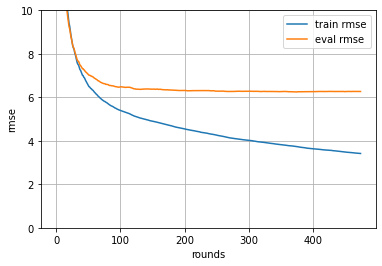

In [30]:
plt.plot(train_metric, label='train rmse')
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.ylim(0, 10)

plt.xlabel('rounds')
plt.ylabel('rmse')
plt.grid(True)
plt.show()

In [31]:
params_grid = {
    'alpha': 10 ** np.arange(-6, 1, 0.1)
}
# パラメータチューニング
clf = GridSearchCV(
    estimator = Ridge(),
    param_grid = params_grid,
    cv = 5,
    scoring='r2',
    n_jobs = -1
    )
# 線形モデルの重みを学習
clf.fit(X_train_scaler, y_train) 

# チューニングしたモデル
best_param = clf.best_params_
ridge_tuned = clf.best_estimator_

# 予測値を反映
y_ridge_pred = ridge_tuned.predict(X_train_scaler) # Trainデータに対して予測
y_ridge_test_pred = ridge_tuned.predict(X_test_scaler) # Testデータに対して予測

#print("α = {}".format(clf.alpha_))
#print("ω = {}".format(clf.coef_))
#print("b = {}".format(clf.intercept_))
print(best_param)
print("R^2 = {}".format(clf.score(X_train_scaler, y_train)))
print("MAE = {}".format(mean_absolute_error(y_train, y_ridge_pred)))

{'alpha': 1e-06}
R^2 = 0.8227281803942648
MAE = 5.273054120466753


In [32]:
y_total_pred = y_lasso_pred*0.0 + y_ridge_pred*0.0 + y_svc_pred*1.0

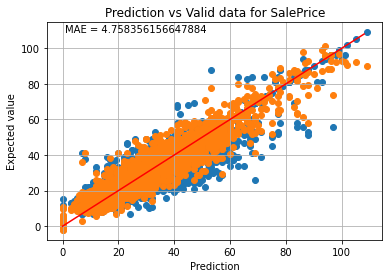

In [33]:
#plt.scatter(y_train, y_lasso_pred)
#plt.scatter(y_train, y_ridge_pred)
plt.scatter(y_train, y_svc_pred)
plt.scatter(y_train, y_lgb_oof_train)
#plt.scatter(y_train, y_total_pred)



plt.title("Prediction vs Valid data for SalePrice")
plt.xlabel("Prediction")
plt.ylabel("Expected value")
# Fitting line
x = np.arange(0, max(y_train))
y = x
plt.plot(x,y,color='red')

# MAE
#result_mae = mean_absolute_error(y_train, y_total_pred)
result_mae = mean_absolute_error(y_train, y_lgb_oof_train)
#result_rmsle = rmsle(y_train.values, y_lgb_oof_train)

plt.text(1, max(y_train), 'MAE = {}'.format(result_mae))

# Grid on
plt.grid(True)

In [34]:
# Average of Prediction data 
y_lgb_test_pred = sum(y_lgb_preds)/len(y_lgb_preds)

In [35]:
submit_sample[1] = y_lgb_test_pred
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [36]:
submit_sample.head()

,0,1
0,2016-04-01,79.949189
1,2016-04-02,84.818843
2,2016-04-03,71.621613
3,2016-04-04,67.372086
4,2016-04-05,63.649101
